# Annual temperature anomalies relative to the pre-industrial period

## Imports

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import nsdiffs, ndiffs

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg
import scipy.stats as stats
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


## EDA


### Reading the Data and creating Time Series


In [169]:
db = pd.read_csv("temperature-anomaly.csv")
db = db[["Year","Global average temperature anomaly relative to 1861-1890","Lower bound of the annual temperature anomaly (95% confidence interval)","Upper bound of the annual temperature anomaly (95% confidence interval)"]]
db = db.rename(columns={
    "Global average temperature anomaly relative to 1861-1890" : "Anomaly",
    "Lower bound of the annual temperature anomaly (95% confidence interval)" : "Lower Bound",
    "Upper bound of the annual temperature anomaly (95% confidence interval)" : "Upper Bound"
})
print(db.head())

   Year   Anomaly  Lower Bound  Upper Bound
0  1850 -0.055414    -0.226959     0.116131
1  1851  0.128948    -0.049570     0.307466
2  1852  0.132899    -0.047085     0.312882
3  1853  0.091943    -0.067712     0.251598
4  1854  0.070777    -0.070414     0.211968


In [170]:
dates = pd.date_range(start='1850', periods=len(db), freq='YE')
mytimeseries = pd.DataFrame(db.iloc[:, 1:].values, index=dates, columns=db.columns[1:])

print("\nTime series info:")
print(mytimeseries.info())
print(mytimeseries.head())


Time series info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 1850-12-31 to 2025-12-31
Freq: YE-DEC
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Anomaly      176 non-null    float64
 1   Lower Bound  176 non-null    float64
 2   Upper Bound  176 non-null    float64
dtypes: float64(3)
memory usage: 5.5 KB
None
             Anomaly  Lower Bound  Upper Bound
1850-12-31 -0.055414    -0.226959     0.116131
1851-12-31  0.128948    -0.049570     0.307466
1852-12-31  0.132899    -0.047085     0.312882
1853-12-31  0.091943    -0.067712     0.251598
1854-12-31  0.070777    -0.070414     0.211968


For this analysis, the primary focus is on the global average temperature anomaly, for which our dataset has data with anual frequency from the Industrial Revolution to the present day (1850-2025, 175 years). While the dataset provides upper and lower bounds to indicate uncertainty, these values are not essential for understanding the overall trend. The average anomaly alone captures how much the Earth's surface temperature has deviated from pre-industrial levels each year, which is why only the average anomaly will be used from here on out.

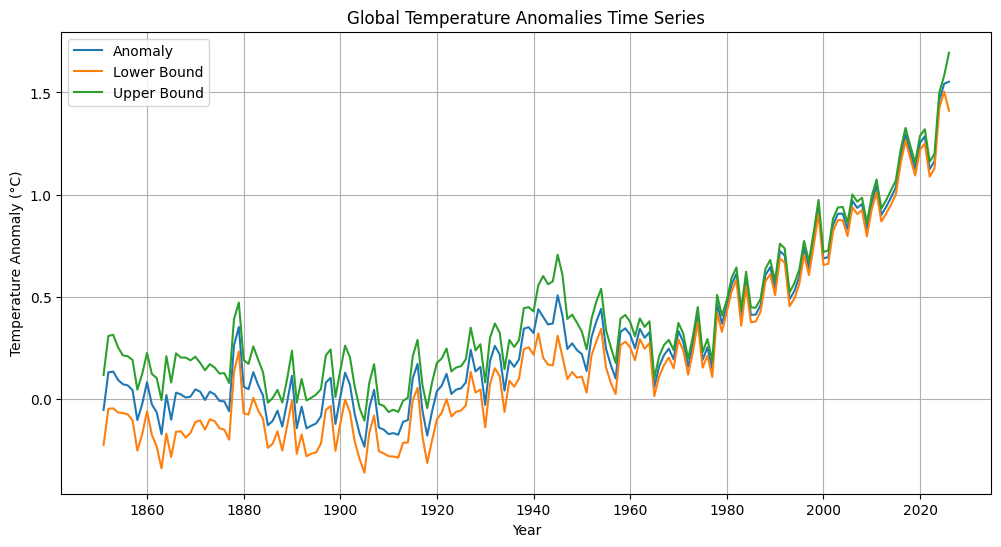

In [171]:
plt.figure(figsize=(12, 6))
for col in mytimeseries.columns:
    plt.plot(mytimeseries.index, mytimeseries[col], label=col)

plt.title("Global Temperature Anomalies Time Series")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.legend()
plt.show()

By concentrating on the average, we can clearly observe the long-term warming trend without the distraction of additional columns. This simplification makes the analysis cleaner, easier to interpret, and directly highlights the magnitude of global temperature changes over time.

### Descriptive Analysis of the Time Series

The series shows a clear upward trend over the past 170+ years, indicating a gradual increase in global temperatures relative to
   pre-industrial levels.

Although there is a general warming trend, the anomalies fluctuate from year to year, with some years being cooler or warmer than the previous year.

The early 20th century shows relatively small deviations, while the late 20th and early 21st centuries exhibit larger positive anomalies, with record highs in recent decades.

The warming trend is gradual over decades, rather than abrupt jumps, although occasional short-term dips are visible due to natural variability.


### Time Series Components

In this section, we analyze the main components of the dataset before applying a formal time series decomposition.

#### 1. Trend
The series shows a **clear upward trend** in global temperature anomalies.
The trend is not perfectly linear: warming is modest before the mid-20th century and accelerates strongly in recent decades.

#### 2. Seasonality

Since the data is **annual** and aggregated at the **global level**, no intra-year seasonal pattern can be observed.
- Hemispheric seasons cancel each other out (summer in one hemisphere corresponds to winter in the other).
- Furthermore, the anomaly calculation is performed relative to a baseline climatology, which already removes the average seasonal cycle.

As a result, this dataset only reflects **long-term trend** and **year-to-year variability**, but not seasonal fluctuations.


#### 3. Variance and Heteroscedasticity
Some evidence of heteroscedasticity is present. In earlier decades (late 19th and early 20th century), the spread of anomalies appears wider. Over time, the range between upper and lower fluctuations narrows.

This narrowing is largely due to **improvements in scientific measurement and global coverage** rather than a real change in climate variability. As more weather stations, ocean buoys, and later satellites were incorporated, the estimates of global temperature anomalies became more precise, reducing uncertainty.

Thus, while the variance of the series shows modest changes, these are best interpreted as **data quality effects** rather than fundamental changes in climate dynamics.

#### 4. Additive vs Multiplicative Structure
Despite small changes in variance, the dataset is best represented by an **additive model**:


$$y_t=T_t + R_t$$


- The **trend** captures the long-term warming signal.
- The **noise** represents short-term variability .
- A multiplicative model is not appropriate, since fluctuations do not scale with the level of the series.



### Time Series Decomposition

In this section we separate the series into its core parts to understand what drives the behavior: a smooth trend (long-run warming) and a remainder (short-run fluctuations). Annual data have no within-year seasonality, so a seasonal component is not modeled.

#### Method (additive, annual)

#### 1. Smoothing for Trend
- **LOWESS:** a locally weighted smoother that traces the central path while ignoring year-to-year noise.

#### 2. Remainder
We define the remainder as the observed anomaly minus the smooth trend:
$$
\mathrm{Remainder}_t \;=\; \mathrm{Anomaly}_t \;-\; \widehat{\mathrm{Trend}}_t
$$

We analyze the remainder to check **serial correlation** (persistence) and **variance changes** (heteroscedasticity).

#### 3. Uncertainty
We visualize the **95% confidence band** (*Lower Bound* / *Upper Bound*) around the anomaly to communicate **estimation uncertainty**.


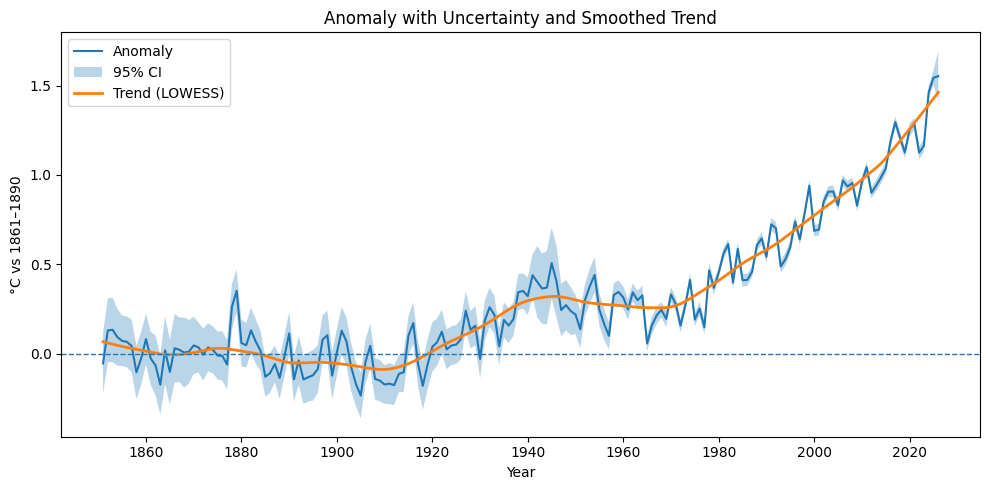

In [172]:
ts = mytimeseries[['Anomaly','Lower Bound','Upper Bound']].sort_index()
x      = np.arange(len(ts))                            
years  = ts.index.to_pydatetime()                         
an     = ts['Anomaly'].to_numpy(dtype=float)
lo_ci  = ts['Lower Bound'].to_numpy(dtype=float)
hi_ci  = ts['Upper Bound'].to_numpy(dtype=float)


low = lowess(an, x, frac=0.15, return_sorted=False)      
remainder = an - low

plt.figure(figsize=(10,5))
plt.plot(years, an, label='Anomaly')
plt.fill_between(years, lo_ci, hi_ci, alpha=0.3, label='95% CI')
plt.plot(years, low, linewidth=2, label='Trend (LOWESS)')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Anomaly with Uncertainty and Smoothed Trend')
plt.xlabel('Year'); plt.ylabel('°C vs 1861–1890'); plt.legend()
plt.tight_layout(); plt.show()

The LOWESS smoother isolates the underlying signal from the annual noise, revealing a persistent long-run warming trend. While the early decades hover near the baseline, the trendline exhibits a distinct upward inflection moving into the 20th century and rises more sharply in recent decades, which is consistent with the acceleration of global warming.

#### **Remainder**

We observed the remainder to look for the following:
- Is it centered around 0 (no lingering trend)?
- Is the variance roughly stable or does it change over time?
- Is there serial correlation (do changes cluster from year to year)?


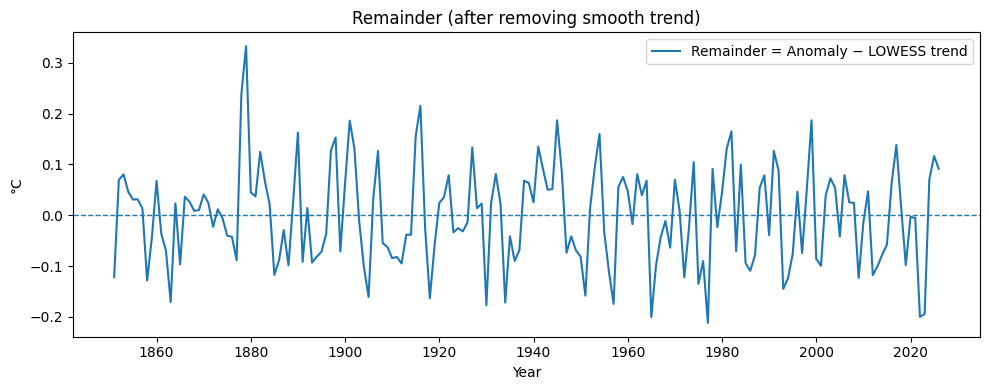

In [173]:
plt.figure(figsize=(10,4))
plt.plot(years, remainder, label='Remainder = Anomaly − LOWESS trend')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Remainder (after removing smooth trend)')
plt.xlabel('Year'); plt.ylabel('°C'); plt.legend()
plt.tight_layout(); plt.show()


After extracting a smooth trend, the remainder is approximately mean-zero, indicating the trend captures the long-run warming. The remainder exhibits brief runs and a few spikes, consistent with short-run variability. Year-to-year changes (first differences) fluctuate around zero but occur in bursts, suggesting short-run persistence rather than pure white noise. The amplitude of deviations is generally modest (≈ ±0.1 °C, with occasional ±0.2–0.3 °C), and the spread appears to vary somewhat across periods, hinting at heteroscedasticity.

- **Centered at zero:** Year-to-year changes bounce around 0 → no leftover trend in the differences.
- **Bursts of larger moves:** Periods with consecutive positive or negative changes indicate **persistence** (changes aren’t purely random).
- **Magnitude:** Typical fluctuations are small (a few hundredths of a degree), with occasional years showing jumps near **±0.2–0.3 °C**.

**Conclusion:** ΔAnomaly shows **non-random clustering** of annual changes, suggesting some **serial dependence** in the short run (common in climate time series).


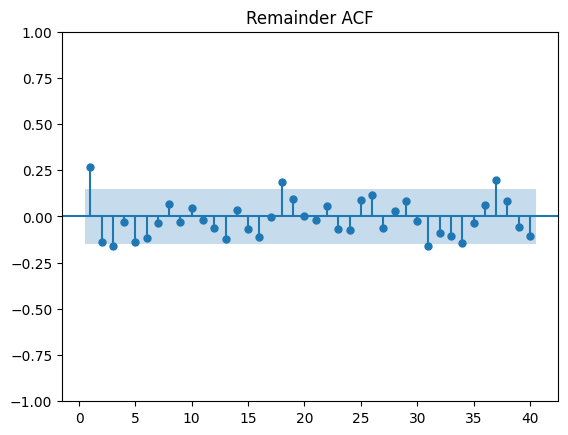

In [174]:
acf = plot_acf(remainder, bartlett_confint=False, lags=40, zero=False, title="Remainder ACF")

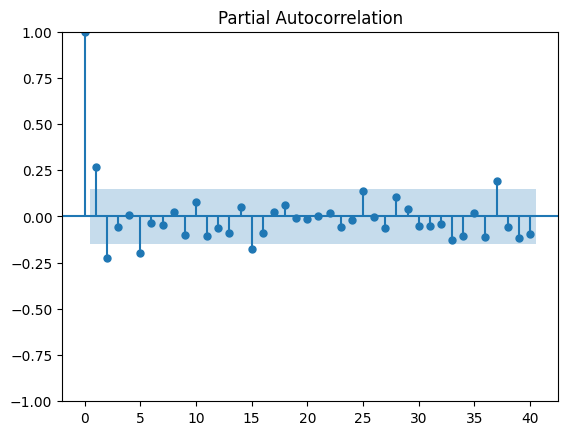

In [175]:
plot_pacf(remainder, lags=40, method='ywm');

In [176]:
df_remainder = pd.DataFrame({
    'Year': years,
    'Remainder': remainder
})
df_remainder['Year'] = df_remainder['Year'].dt.year

In [177]:
temptrain=df_remainder[df_remainder['Year']<=1990]
temptest=df_remainder[df_remainder['Year']>1990]
print ("Treino: ", temptrain.shape)
print ("Teste: ",temptest.shape)

Treino:  (141, 2)
Teste:  (35, 2)


In [178]:
train_series = temptrain.set_index('Year')['Remainder']
test_series = temptest.set_index('Year')['Remainder']

In [179]:
D = nsdiffs(df_remainder['Remainder'], m=12, test='ocsb')

print(f"Seasonal Differences required (D): {D}")

Seasonal Differences required (D): 0


In [180]:
ND=ndiffs(df_remainder['Remainder'])

print(f"Non-Seasonal Differences required (ND): {ND}")

Non-Seasonal Differences required (ND): 0


Based on the plots and the calculated value ND=0, the analysis confirms that the long-term trend has been effectively removed from the data. The Autocorrelation Function (ACF) plot shows a quick drop-off to near zero, which indicates that the warming trend is no longer dominating the series and the data is now stationary with a constant mean. There is a significant spike at Lag 1, suggesting that while the long-term trend is gone, there is still some short-term memory or persistence where an abnormally hot year tends to be followed by another somewhat hotter-than-average year.

Regarding seasonality, the visual evidence from the ACF plot aligns with the statistical test result of D=0. The ACF plot displays no repeating rhythmic spikes at intervals like 12, 24, or 36, which you would expect if there were a seasonal cycle. This confirms that the data is non-seasonal, which makes sense for annual global anomalies where seasonal weather differences are averaged out.

## Modeling  
Considering that in our data there is no seasonality, we will focus on models with any seasonal component.

### AR Model

In order to figure the adequate order for our AR model, we will need to analyse the PACF. There is an evident cut-off in lag 3, which indicates that our AR model should have an order of 3. However, we will test AR models with order 1, 2 and 3 to reach a definite conclusion.

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 135.188
Date:                Mon, 15 Dec 2025   AIC                           -264.375
Time:                        04:12:20   BIC                           -255.529
Sample:                             0   HQIC                          -260.780
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.011      0.093      0.926      -0.020       0.022
ar.L1          0.2712      0.076      3.583      0.000       0.123       0.420
sigma2         0.0086      0.001      7.918      0.0

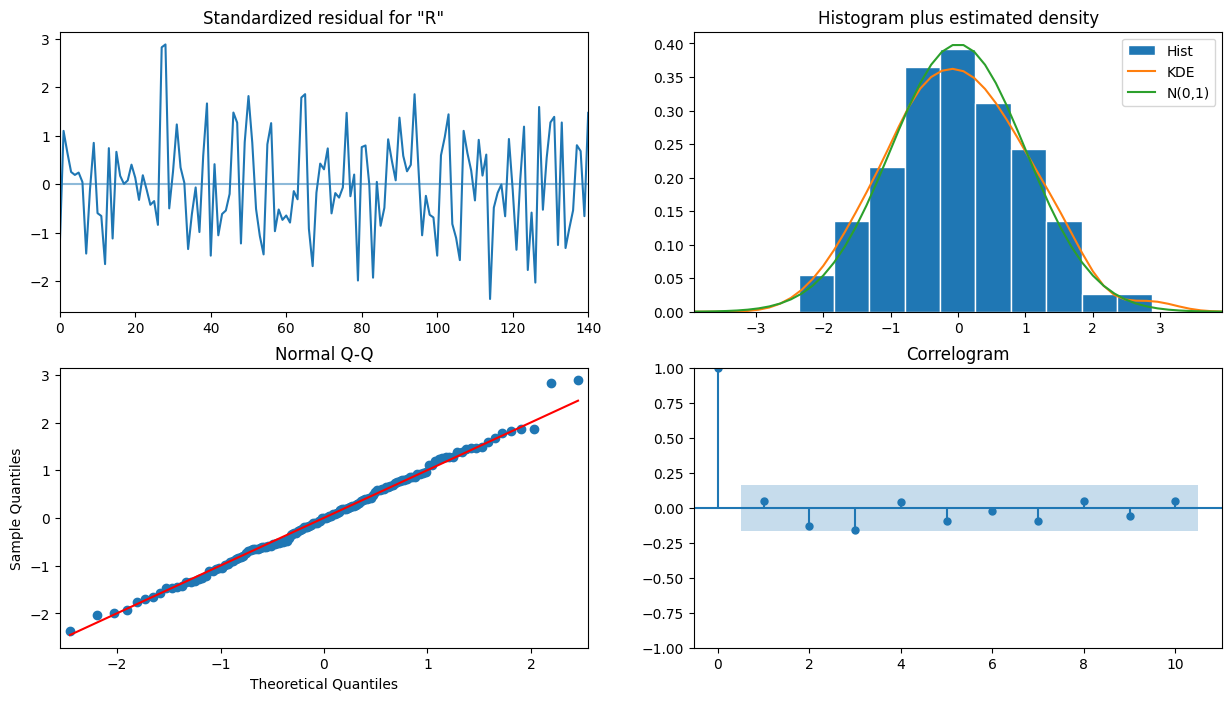

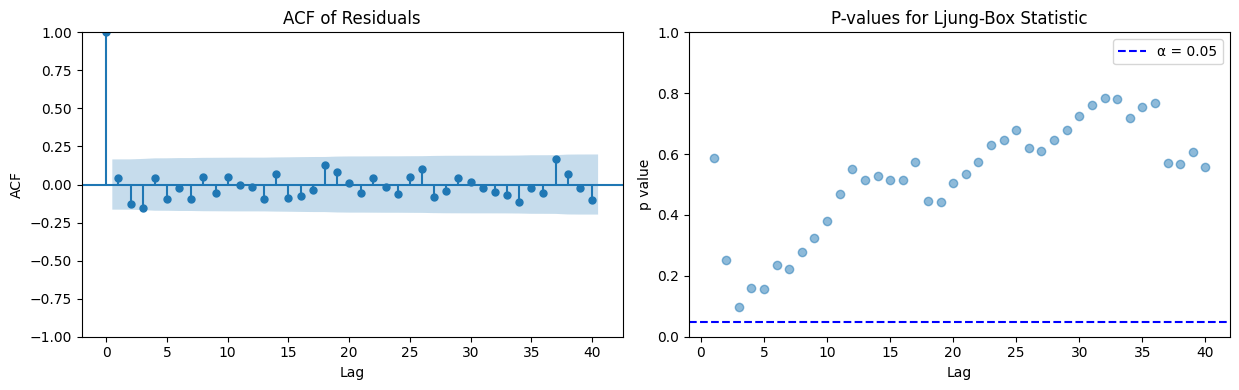

In [181]:
modelAR1 = ARIMA(train_series, order=(1,0,0)).fit()
print(modelAR1.summary())

modelAR1_residuos = modelAR1.resid
modelAR1.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelAR1_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelAR1_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 137.417
Date:                Mon, 15 Dec 2025   AIC                           -266.834
Time:                        04:12:21   BIC                           -255.039
Sample:                             0   HQIC                          -262.041
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.009      0.106      0.915      -0.017       0.019
ar.L1          0.3221      0.077      4.164      0.000       0.171       0.474
ar.L2         -0.1784      0.087     -2.044      0.0

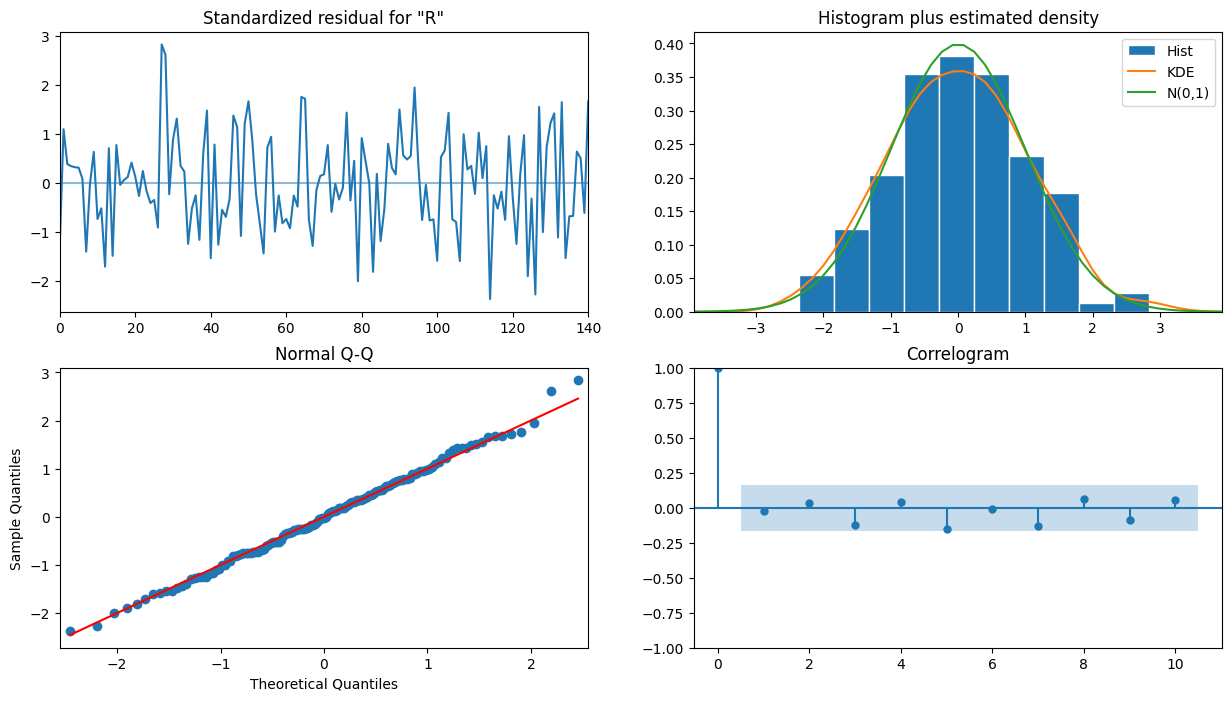

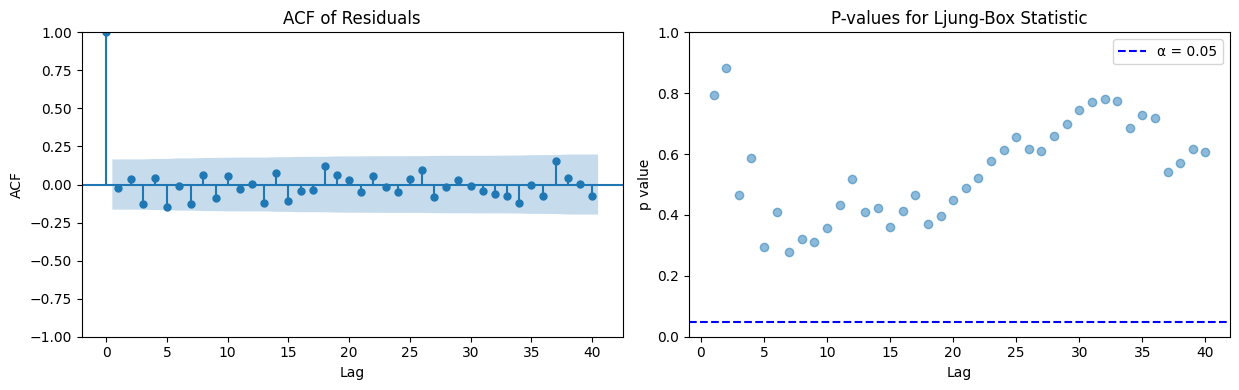

In [182]:
modelAR2 = ARIMA(train_series, order=(2,0,0)).fit()
print(modelAR2.summary())

modelAR2_residuos = modelAR2.resid
modelAR2.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelAR2_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelAR2_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 138.133
Date:                Mon, 15 Dec 2025   AIC                           -266.266
Time:                        04:12:23   BIC                           -251.522
Sample:                             0   HQIC                          -260.274
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.009      0.098      0.922      -0.016       0.017
ar.L1          0.3032      0.078      3.884      0.000       0.150       0.456
ar.L2         -0.1440      0.091     -1.576      0.1

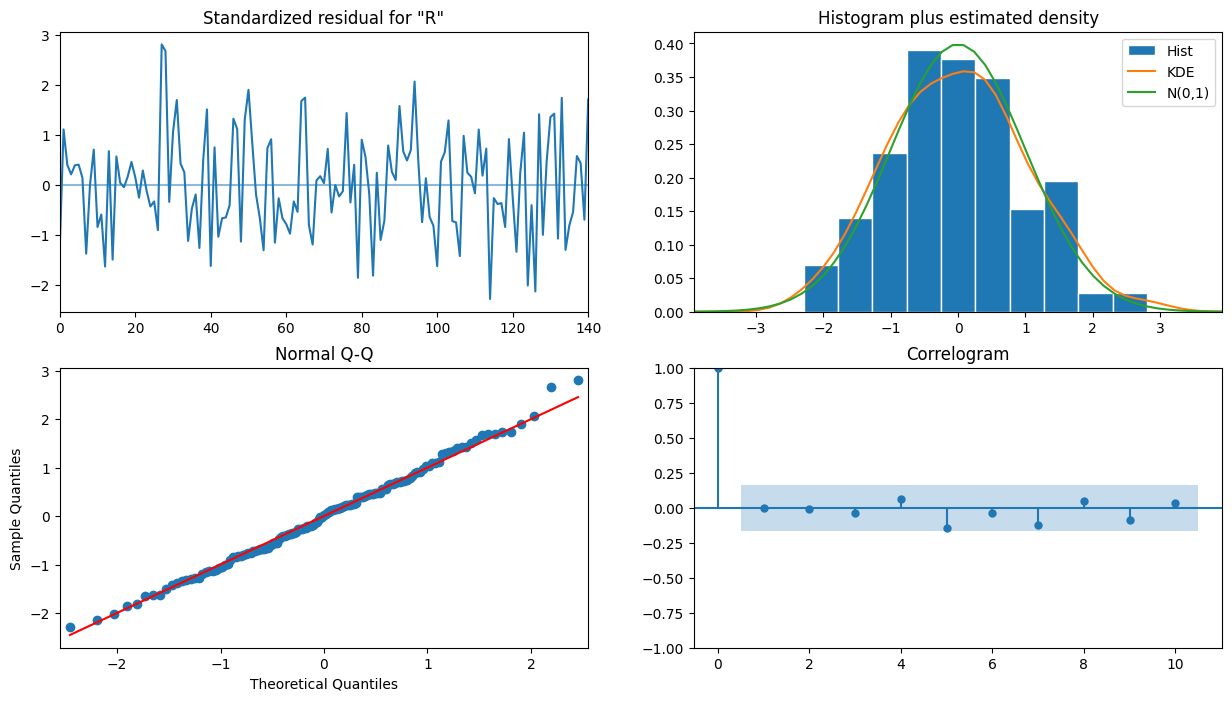

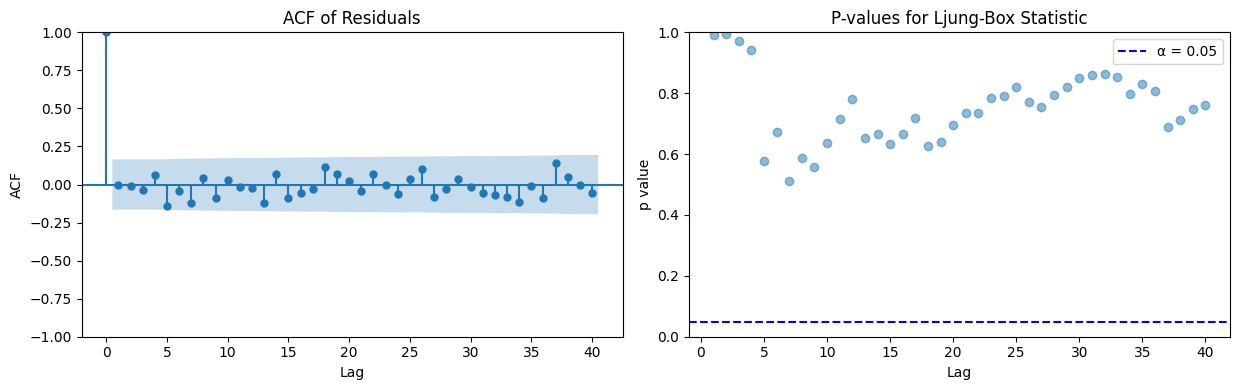

In [183]:
modelAR3 = ARIMA(train_series, order=(3,0,0)).fit()
print(modelAR3.summary())

modelAR3_residuos = modelAR3.resid
modelAR3.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelAR3_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelAR3_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

In [184]:
ar_report = f"""
|   Model   |    BIC    |    AIC    |    AICc   |
|-----------|-----------|-----------|-----------|
|   AR(1)   | {(modelAR1.bic/len(temptrain)):.6f} | {(modelAR1.aic/len(temptrain)):.6f} | {(modelAR1.aicc/len(temptrain)):.6f} |
|   AR(2)   | {(modelAR2.bic/len(temptrain)):.6f} | {(modelAR2.aic/len(temptrain)):.6f} | {(modelAR2.aicc/len(temptrain)):.6f} |
|   AR(3)   | {(modelAR3.bic/len(temptrain)):.6f} | {(modelAR3.aic/len(temptrain)):.6f} | {(modelAR3.aicc/len(temptrain)):.6f} |
"""
print(ar_report)


|   Model   |    BIC    |    AIC    |    AICc   |
|-----------|-----------|-----------|-----------|
|   AR(1)   | -1.812261 | -1.875001 | -1.873758 |
|   AR(2)   | -1.808786 | -1.892439 | -1.890353 |
|   AR(3)   | -1.783844 | -1.888410 | -1.885257 |



For all 3 parameters, the AR model seems to be an adequate model since the residuals are never correlated or with p-values above 0.05. If we take into account the AIC, AICc and BIC results, the best model would be AR(2). However, on all 3 models there is always at least one coefficient that is not statistically significant, thus implying that the AR models are not the best fit.  
Let's then try the MA models. We must figure the q periods to use on the MA(q) model. By looking at our original residual ACF, there is an evident cut-off on lag 2, which might indicate MA(2) as the model to use. However, just like with AR models, we will try MA(1), MA(2) and MA(3).

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 136.278
Date:                Mon, 15 Dec 2025   AIC                           -266.556
Time:                        04:12:25   BIC                           -257.709
Sample:                             0   HQIC                          -262.961
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.010      0.099      0.921      -0.019       0.021
ma.L1          0.3071      0.072      4.241      0.000       0.165       0.449
sigma2         0.0085      0.001      7.937      0.0

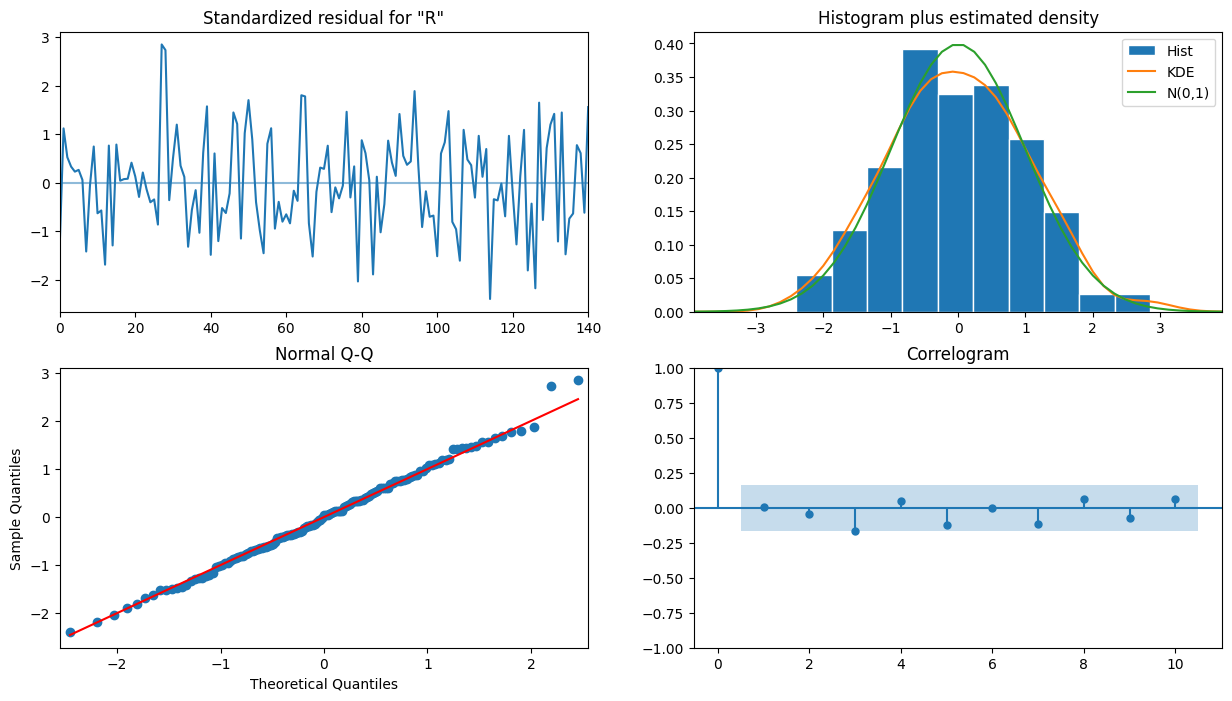

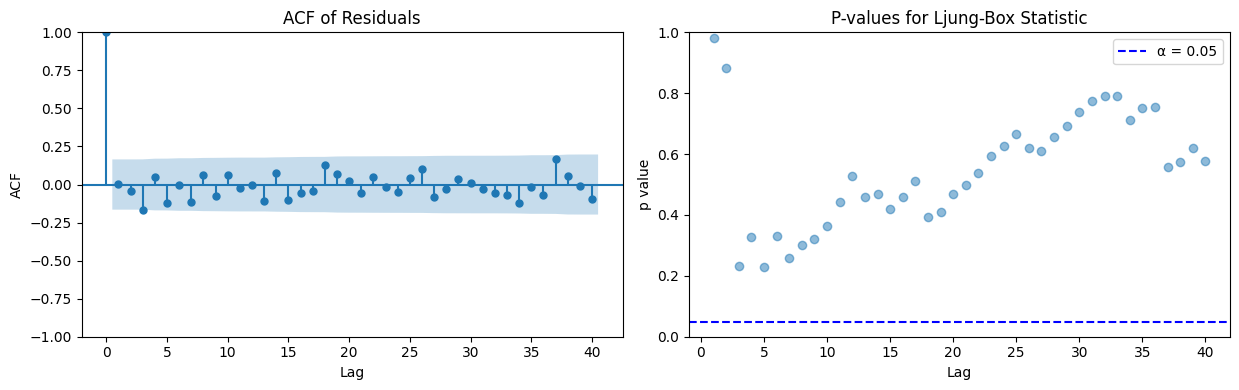

In [185]:
modelMA1 = ARIMA(train_series, order=(0,0,1)).fit()
print(modelMA1.summary())

modelMA1_residuos = modelMA1.resid
modelMA1.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelMA1_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelMA1_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 136.299
Date:                Mon, 15 Dec 2025   AIC                           -264.599
Time:                        04:12:26   BIC                           -252.804
Sample:                             0   HQIC                          -259.806
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.011      0.095      0.925      -0.020       0.022
ma.L1          0.3192      0.076      4.174      0.000       0.169       0.469
ma.L2          0.0190      0.094      0.201      0.8

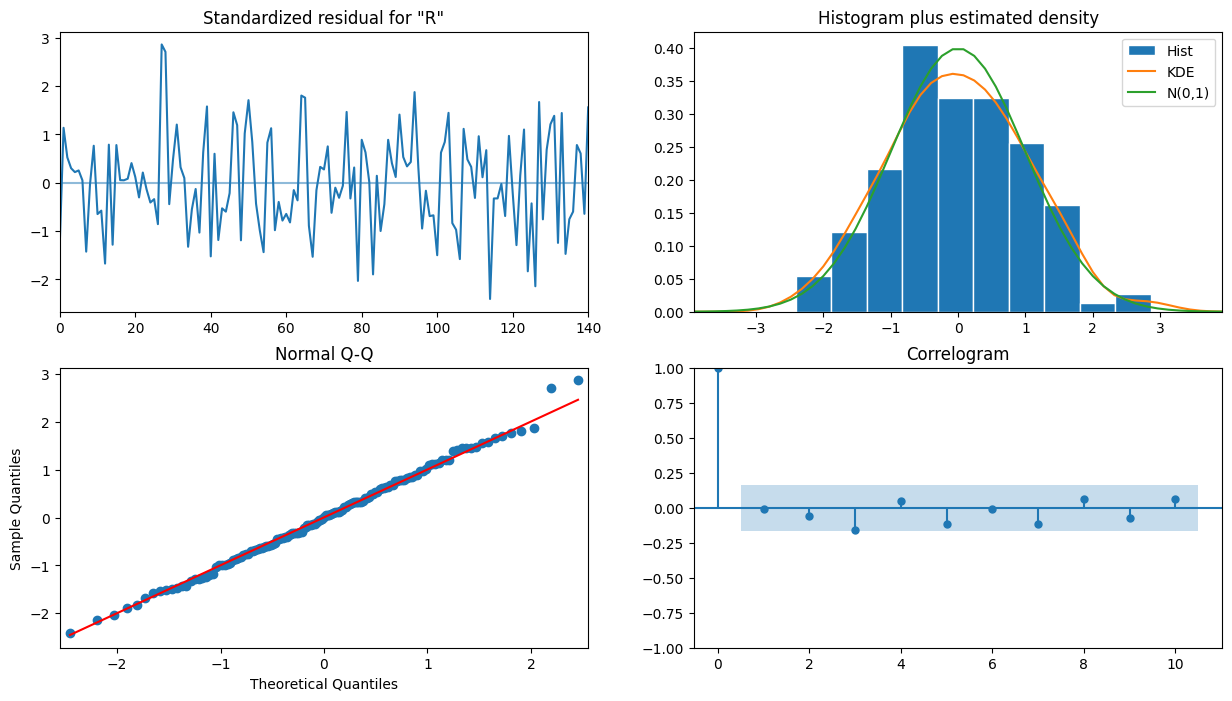

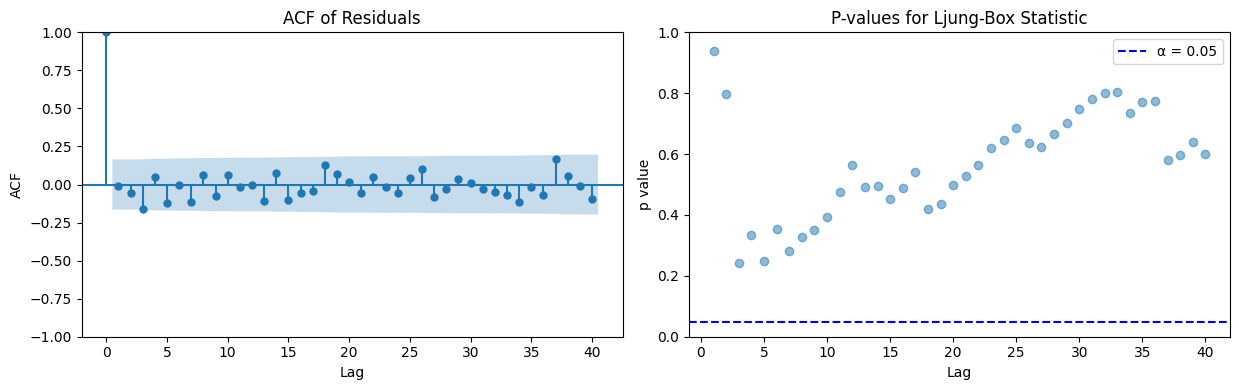

In [186]:
modelMA2 = ARIMA(train_series, order=(0,0,2)).fit()
print(modelMA2.summary())

modelMA2_residuos = modelMA2.resid
modelMA2.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelMA2_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelMA2_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(0, 0, 3)   Log Likelihood                 139.109
Date:                Mon, 15 Dec 2025   AIC                           -268.219
Time:                        04:12:28   BIC                           -253.475
Sample:                             0   HQIC                          -262.227
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.008      0.105      0.916      -0.015       0.017
ma.L1          0.3078      0.076      4.028      0.000       0.158       0.457
ma.L2         -0.0936      0.095     -0.990      0.3

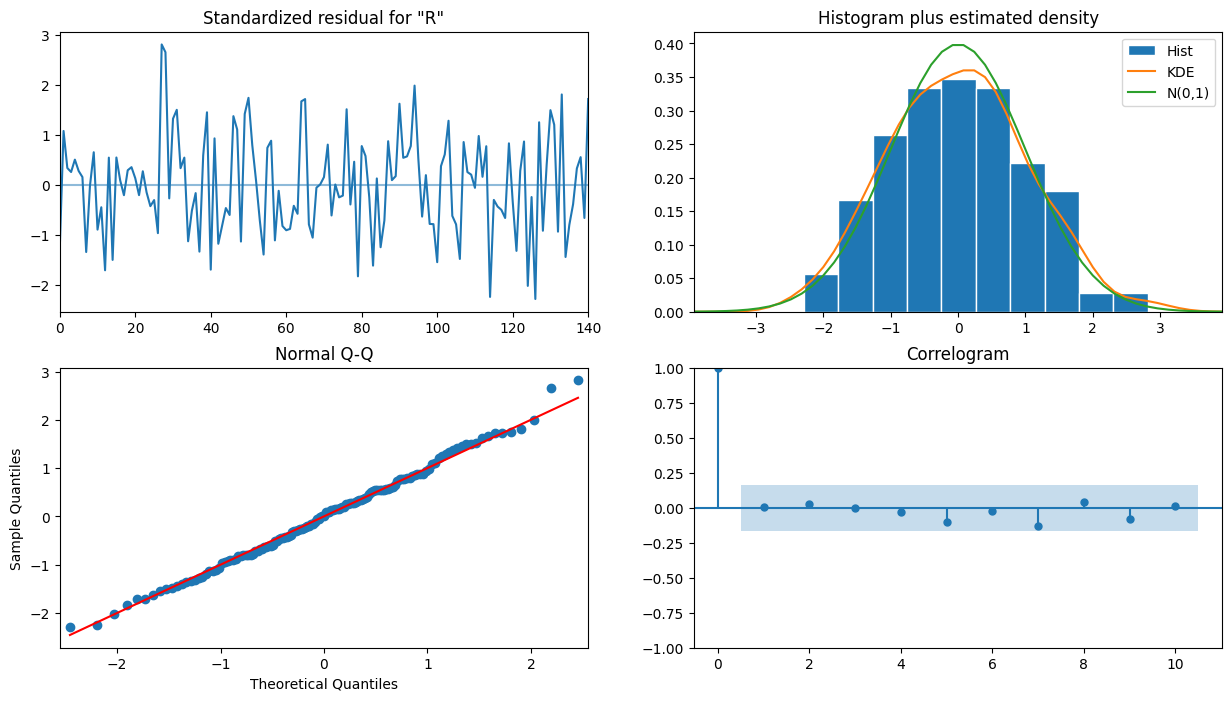

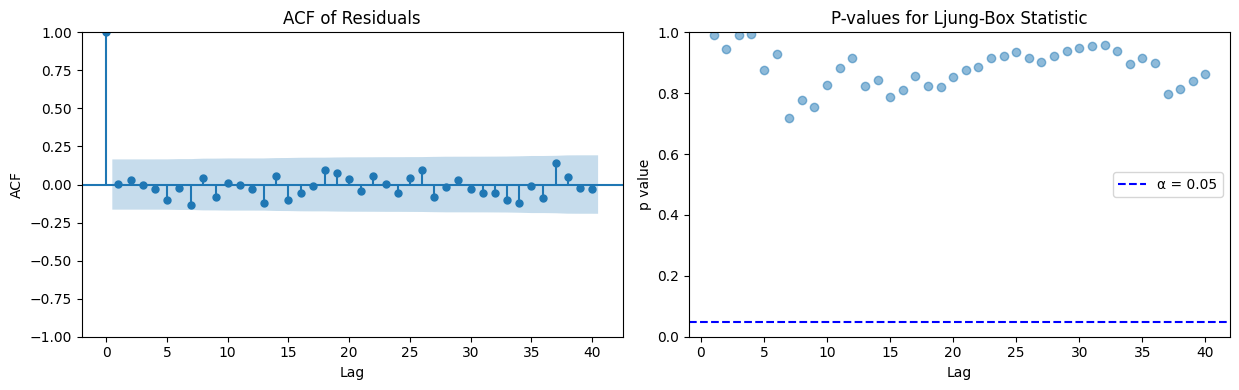

In [187]:
modelMA3 = ARIMA(train_series, order=(0,0,3)).fit()
print(modelMA3.summary())

modelMA3_residuos = modelMA3.resid
modelMA3.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelMA3_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelMA3_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

In [188]:
ma_report = f"""
|   Model   |    BIC    |    AIC    |    AICc   |
|-----------|-----------|-----------|-----------|
|   MA(1)   | {(modelMA1.bic/len(temptrain)):.6f} | {(modelMA1.aic/len(temptrain)):.6f} | {(modelMA1.aicc/len(temptrain)):.6f} |
|   MA(2)   | {(modelMA2.bic/len(temptrain)):.6f} | {(modelMA2.aic/len(temptrain)):.6f} | {(modelMA2.aicc/len(temptrain)):.6f} |
|   MA(3)   | {(modelMA3.bic/len(temptrain)):.6f} | {(modelMA3.aic/len(temptrain)):.6f} | {(modelMA3.aicc/len(temptrain)):.6f} |
"""
print(ma_report)


|   Model   |    BIC    |    AIC    |    AICc   |
|-----------|-----------|-----------|-----------|
|   MA(1)   | -1.827727 | -1.890466 | -1.889224 |
|   MA(2)   | -1.792933 | -1.876586 | -1.874500 |
|   MA(3)   | -1.797693 | -1.902259 | -1.899107 |



Again, looking at the 3 models, all show uncorrelated residuals and with p-values for the Ljung-Box test below 0.05, thus none is automatically excluded. If we take into account the measures  AIC, BIC and AICc then the best model is the MA(3). However, similar to what happened with the AR models, there's always one coefficient that is not statistically significant.
Let's then try an ARMA model with the best parameters identified above for each of the AR and MA models, ARMA(2,3).

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 143.425
Date:                Mon, 15 Dec 2025   AIC                           -272.849
Time:                        04:12:30   BIC                           -252.208
Sample:                             0   HQIC                          -264.461
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.601      0.548      -0.003       0.006
ar.L1         -0.0821      0.113     -0.729      0.466      -0.303       0.139
ar.L2          0.7845      0.112      7.021      0.0

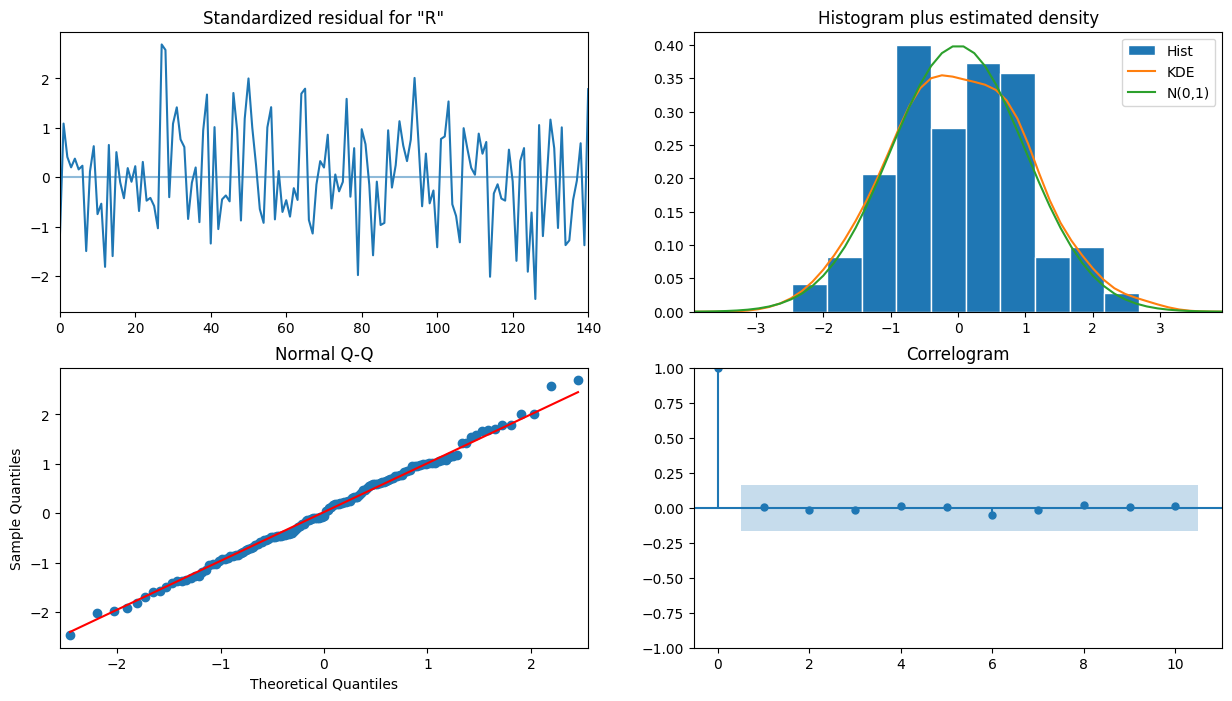

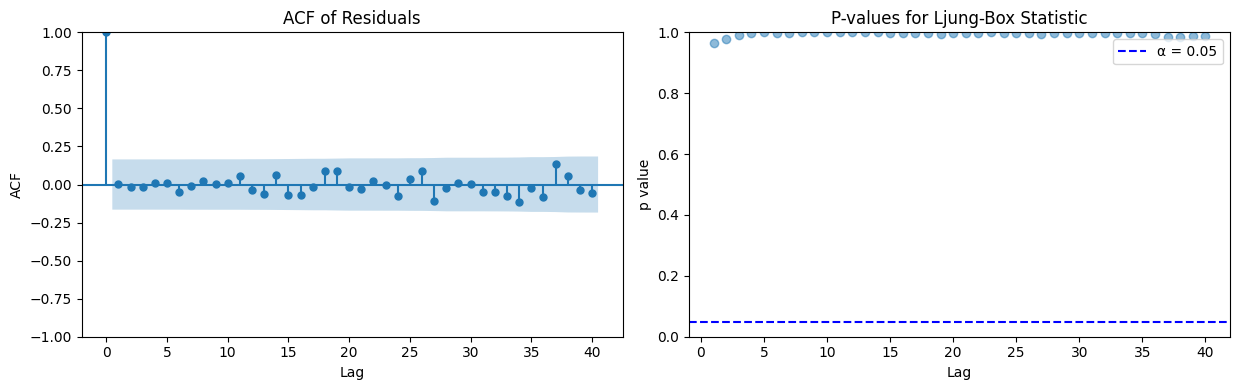

In [189]:
modelARMA = ARIMA(train_series, order=(2,0,3)).fit()
print(modelARMA.summary())

modelARMA_residuos = modelARMA.resid
modelARMA.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelARMA_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelARMA_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

With the ARMA(2,3) model the residuals are not correlated, the p-values for the Ljung-Box test show that for all lags the residuals are statistically significant and all the residuals have a symmetric distribution with slightly heavier tails than the Gaussian. When it comes to the coefficients, all are statistically significant (with the constant being a bit above 0.05, which will not be considered).
Now that the best model for our data is found, it's time to forecast.

## Forecasting

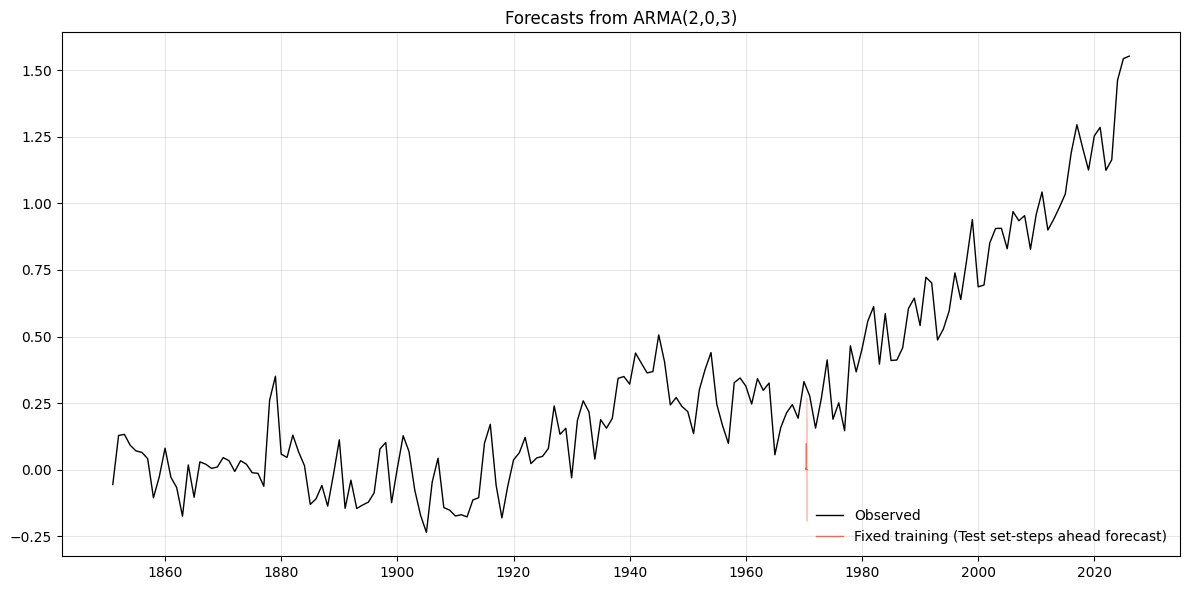

In [190]:
s=len(temptest)
ARMA_fct = modelARMA.forecast(steps=s)

# obtain confidence interval (95%)
forecast_df = modelARMA.get_forecast(steps=s)
forecast_ci = forecast_df.conf_int(alpha=0.05)  # 95% CI

# forecasts plot
fig, ax = plt.subplots(figsize=(12, 6))
# original TS (complete)
ax.plot(ts.index, ts["Anomaly"], color='black', linewidth=1, label='Observed')
# forecasts
ax.plot(ARMA_fct.index, ARMA_fct, color='tomato', linewidth=1, 
        label='Fixed training (Test set-steps ahead forecast)')
# confidence intervale
ax.fill_between(forecast_ci.index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1], 
                color='tomato', alpha=0.3)
ax.set_ylabel('')
ax.set_title('Forecasts from ARMA(2,0,3)')
ax.legend(loc='lower right', frameon=False)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
history = train_series.copy()
predictions = []

for t in test_series.index:
    model = ARIMA(history, order=(2,0,3))
    fit = model.fit()
    
    yhat = fit.forecast(steps=1)
    predictions.append(yhat.iloc[0])
    history = pd.concat([history, test_series.loc[t:t]])

#criar series das previsões
rolling_forecast = pd.Series(predictions, index=test_series.index)

#plot
fig, ax = plt.subplots(figsize=(12, 6))
# série completa
ax.plot(df_remainder.index, df_remainder['Remainder'], color='black', linewidth=1, label='Observed')

# rolling forecast
ax.plot(rolling_forecast.index, rolling_forecast, color='tomato', linewidth=1.5, linestyle='--', label='Rolling ARMA(2,3) forecast')

ax.set_title('Rolling one-step-ahead forecast vs Observed')
ax.set_xlabel('Year')
ax.set_ylabel('')
ax.legend(frameon=False)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

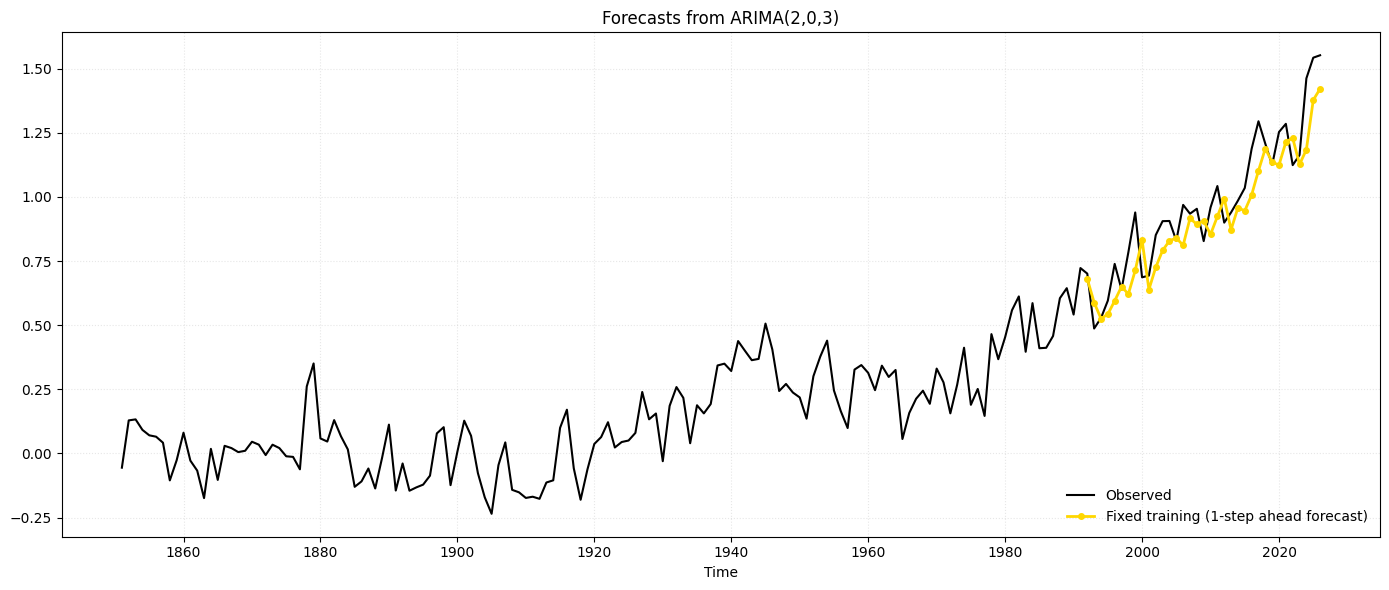


1-step ahead forecasts:
time
1991-12-31    0.680700
1992-12-31    0.588515
1993-12-31    0.525766
1994-12-31    0.543054
1995-12-31    0.594929
1996-12-31    0.650587
1997-12-31    0.621497
1998-12-31    0.713712
1999-12-31    0.832334
2000-12-31    0.639203
2001-12-31    0.726012
2002-12-31    0.791692
2003-12-31    0.828940
2004-12-31    0.840320
2005-12-31    0.811469
2006-12-31    0.916646
2007-12-31    0.893332
2008-12-31    0.907279
2009-12-31    0.853985
2010-12-31    0.924076
2011-12-31    0.993849
2012-12-31    0.872553
2013-12-31    0.958206
2014-12-31    0.946172
2015-12-31    1.007652
2016-12-31    1.102444
2017-12-31    1.188968
2018-12-31    1.135916
2019-12-31    1.124495
2020-12-31    1.214291
2021-12-31    1.230015
2022-12-31    1.126707
2023-12-31    1.184856
2024-12-31    1.377874
2025-12-31    1.421871
Name: 1-step ahead forecast, dtype: float64


In [ ]:
# Prediction 35 times 1-step ahead (rolling forecast)
output = []
for i in range(1, 36):
    # Select data up to the current time + i months
    end_date = mytimeseries.index[140] + relativedelta(years=i)
        
    # Filter expanded training data
    if end_date <= ts.index[-1]:
        # Expand training by including more observations
        extended_train = ts["Anomaly"].loc[:end_date]
        # fix model M1
        fit = ARIMA(extended_train, order=(2, 0, 3)).fit()
        # Get the last adjusted value (1-step ahead)
        fitted_value = fit.fittedvalues.iloc[-1]
        output.append({
            'time': end_date,
            'value': fitted_value
        })
        
  
# convert output to Series
output_df = pd.DataFrame(output)
ARMA_fct_v2 = pd.Series(
    output_df['value'].values, 
    index=pd.DatetimeIndex(output_df['time']),
    name='1-step ahead forecast'
)

# plot forecasts
fig, ax = plt.subplots(figsize=(14, 6))
# original TS (complete)
ax.plot(ts.index, ts["Anomaly"], color='black', linewidth=1.5, label='Observed')
# forecasts 1-step ahead
ax.plot(ARMA_fct_v2.index, ARMA_fct_v2, color='gold', linewidth=2, 
        label='Fixed training (1-step ahead forecast)', marker='o', markersize=4)
ax.set_ylabel('')
ax.set_xlabel('Time')
ax.set_title('Forecasts from ARIMA(2,0,3)')
ax.legend(loc='lower right', frameon=False)
ax.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

# print forecast values
print("\n1-step ahead forecasts:")
print(ARMA_fct_v2)

In [ ]:
# DIAGNÓSTICO RÁPIDO
print("="*60)
print("DIAGNÓSTICO DOS DADOS")
print("="*60)

print("\n1. df_remainder original:")
print(f"   Shape: {df_remainder.shape}")
print(f"   NaNs: {df_remainder.isna().sum().sum()}")
print(f"   Years range: {df_remainder['Year'].min()} - {df_remainder['Year'].max()}")
print(f"   Sample:\n{df_remainder.head()}")

print("\n2. temptrain:")
print(f"   Shape: {temptrain.shape}")
print(f"   Years: {temptrain['Year'].min()} - {temptrain['Year'].max()}")
print(f"   NaNs em Remainder: {temptrain['Remainder'].isna().sum()}")

print("\n3. temptest:")
print(f"   Shape: {temptest.shape}")
print(f"   Years: {temptest['Year'].min()} - {temptest['Year'].max()}")
print(f"   NaNs em Remainder: {temptest['Remainder'].isna().sum()}")

print("\n4. train_series:")
print(f"   Type: {type(train_series)}")
print(f"   Shape: {train_series.shape}")
print(f"   Index type: {type(train_series.index)}")
print(f"   NaNs: {train_series.isna().sum()}")
print(f"   Sample:\n{train_series.head()}")

print("\n5. test_series:")
print(f"   Type: {type(test_series)}")
print(f"   Shape: {test_series.shape}")
print(f"   Index type: {type(test_series.index)}")
print(f"   NaNs: {test_series.isna().sum()}")
print(f"   Sample:\n{test_series.head()}")

# Verificar se há valores infinitos
print(f"\n6. Valores infinitos:")
print(f"   train_series: {np.isinf(train_series).sum()}")
print(f"   test_series: {np.isinf(test_series).sum()}")

DIAGNÓSTICO DOS DADOS

1. df_remainder original:
   Shape: (176, 2)
   NaNs: 0
   Years range: 1850 - 2025
   Sample:
   Year  Remainder
0  1850  -0.121622
1  1851   0.069761
2  1852   0.080503
3  1853   0.046042
4  1854   0.031038

2. temptrain:
   Shape: (141, 2)
   Years: 1850 - 1990
   NaNs em Remainder: 0

3. temptest:
   Shape: (35, 2)
   Years: 1991 - 2025
   NaNs em Remainder: 0

4. train_series:
   Type: <class 'pandas.core.series.Series'>
   Shape: (141,)
   Index type: <class 'pandas.core.indexes.base.Index'>
   NaNs: 0
   Sample:
Year
1850   -0.121622
1851    0.069761
1852    0.080503
1853    0.046042
1854    0.031038
Name: Remainder, dtype: float64

5. test_series:
   Type: <class 'pandas.core.series.Series'>
   Shape: (35,)
   Index type: <class 'pandas.core.indexes.base.Index'>
   NaNs: 0
   Sample:
Year
1991    0.087905
1992   -0.144778
1993   -0.123811
1994   -0.076406
1995    0.046348
Name: Remainder, dtype: float64

6. Valores infinitos:
   train_series: 0
   test_se

A treinar modelo ARMA(2,3) para forecast direto...
Forecast Direto - RMSE: 0.0951, MAE: 0.0794

A executar Rolling Window Forecast...
  Progresso: 10/35 anos processados
  Progresso: 20/35 anos processados
  Progresso: 30/35 anos processados
Rolling Window - RMSE: 0.0889, MAE: 0.0702


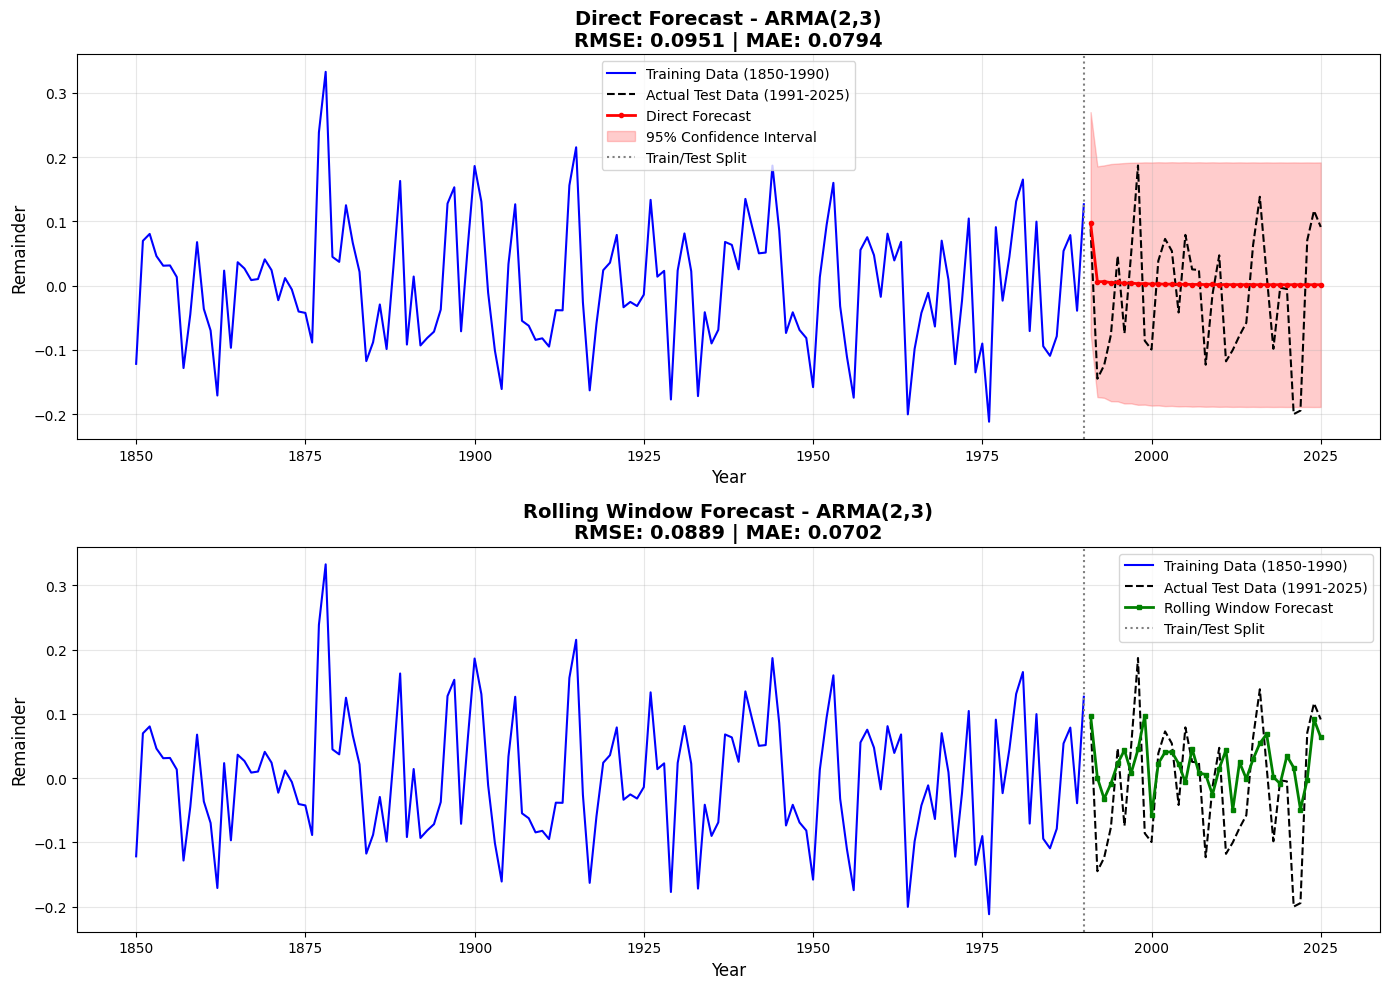

In [ ]:
# 1. Forecast Direto
print("A treinar modelo ARMA(2,3) para forecast direto...")
model_direct = ARIMA(train_series, order=(2, 0, 3))
fitted_direct = model_direct.fit()

# Obter previsões com get_forecast (mais robusto)
forecast_result = fitted_direct.get_forecast(steps=len(test_series))
forecast_direct_mean = forecast_result.predicted_mean

# Criar Series com índice correto
forecast_direct_series = pd.Series(
    forecast_direct_mean.values, 
    index=test_series.index
)
# Obter intervalos de confiança
conf_int_direct = forecast_result.conf_int(alpha=0.05)  # 95% CI
conf_int_direct.index = test_series.index
# Calcular métricas
rmse_direct = np.sqrt(mean_squared_error(test_series, forecast_direct_series))
mae_direct = mean_absolute_error(test_series, forecast_direct_series)

print(f"Forecast Direto - RMSE: {rmse_direct:.4f}, MAE: {mae_direct:.4f}")

# 2. Rolling Window
print("\nA executar Rolling Window Forecast...")
rolling_predictions = []
rolling_years = []

for i in range(len(test_series)):
    # Expandir janela de treino até ao ano atual
    current_year = test_series.index[i]
    train_data = df_remainder[df_remainder['Year'] <= (1990 + i)].set_index('Year')['Remainder']
    
    # Treinar modelo
    model_rolling = ARIMA(train_data, order=(2, 0, 3))
    fitted_rolling = model_rolling.fit()
    
    # Prever apenas 1 passo à frente
    pred = fitted_rolling.forecast(steps=1)
    rolling_predictions.append(pred.iloc[0] if hasattr(pred, 'iloc') else pred[0])
    rolling_years.append(current_year)
    
    if (i + 1) % 10 == 0:
        print(f"  Progresso: {i+1}/{len(test_series)} anos processados")

rolling_predictions_series = pd.Series(rolling_predictions, index=rolling_years)

# Calcular métricas
rmse_rolling = np.sqrt(mean_squared_error(test_series, rolling_predictions_series))
mae_rolling = mean_absolute_error(test_series, rolling_predictions_series)

print(f"Rolling Window - RMSE: {rmse_rolling:.4f}, MAE: {mae_rolling:.4f}")

# 3. Gráficos
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
#3.1 Forecasting direto
ax1 = axes[0]

# Dados históricos de treino
ax1.plot(train_series.index, train_series.values, 
         label='Training Data (1850-1990)', color='blue', linewidth=1.5)

# Dados reais de teste
ax1.plot(test_series.index, test_series.values, 
         label='Actual Test Data (1991-2025)', color='black', linewidth=1.5, linestyle='--')

# Forecast direto
ax1.plot(forecast_direct_series.index, forecast_direct_series.values, 
         label='Direct Forecast', color='red', linewidth=2, marker='o', markersize=3)

# Intervalos de confiança
ax1.fill_between(test_series.index, 
                 conf_int_direct.iloc[:, 0], 
                 conf_int_direct.iloc[:, 1], 
                 color='red', alpha=0.2, label='95% Confidence Interval')

ax1.axvline(x=1990, color='gray', linestyle=':', linewidth=1.5, label='Train/Test Split')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Remainder', fontsize=12)
ax1.set_title(f'Direct Forecast - ARMA(2,3)\nRMSE: {rmse_direct:.4f} | MAE: {mae_direct:.4f}', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 3.2 Rolling Window
ax2 = axes[1]

# Dados históricos de treino
ax2.plot(train_series.index, train_series.values, 
         label='Training Data (1850-1990)', color='blue', linewidth=1.5)

# Dados reais de teste
ax2.plot(test_series.index, test_series.values, 
         label='Actual Test Data (1991-2025)', color='black', linewidth=1.5, linestyle='--')

# Rolling window forecast
ax2.plot(rolling_predictions_series.index, rolling_predictions_series.values, 
         label='Rolling Window Forecast', color='green', linewidth=2, marker='s', markersize=3)

ax2.axvline(x=1990, color='gray', linestyle=':', linewidth=1.5, label='Train/Test Split')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Remainder', fontsize=12)
ax2.set_title(f'Rolling Window Forecast - ARMA(2,3)\nRMSE: {rmse_rolling:.4f} | MAE: {mae_rolling:.4f}', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#4. COMPARAÇÃO DE MÉTRICAS

print("\n" + "="*60)
print("COMPARAÇÃO DE PERFORMANCE")
print("="*60)
print(f"{'Método':<25} {'RMSE':<15} {'MAE':<15}")
print("-"*60)
print(f"{'Direct Forecast':<25} {rmse_direct:<15.4f} {mae_direct:<15.4f}")
print(f"{'Rolling Window':<25} {rmse_rolling:<15.4f} {mae_rolling:<15.4f}")
print("="*60)

# Melhor método
if rmse_rolling < rmse_direct:
    print(f"\n✓ Rolling Window é melhor por {((rmse_direct-rmse_rolling)/rmse_direct*100):.2f}%")
else:
    print(f"\n✓ Direct Forecast é melhor por {((rmse_rolling-rmse_direct)/rmse_rolling*100):.2f}%")


COMPARAÇÃO DE PERFORMANCE
Método                    RMSE            MAE            
------------------------------------------------------------
Direct Forecast           0.0951          0.0794         
Rolling Window            0.0889          0.0702         

✓ Rolling Window é melhor por 6.50%


A processar forecast com Expanding Window...
Year       Train Size      Prediction     
----------------------------------------------------------------------
1991       141                   0.097400
1995       145                   0.022963
2000       150                  -0.057985
2005       155                  -0.006724
2010       160                   0.014982
2015       165                   0.029404
2020       170                   0.034642
2025       175                   0.063395
----------------------------------------------------------------------

MÉTRICAS DE PERFORMANCE - EXPANDING WINDOW
RMSE:  0.088883
MAE:   0.070216
MAPE:  110.95%



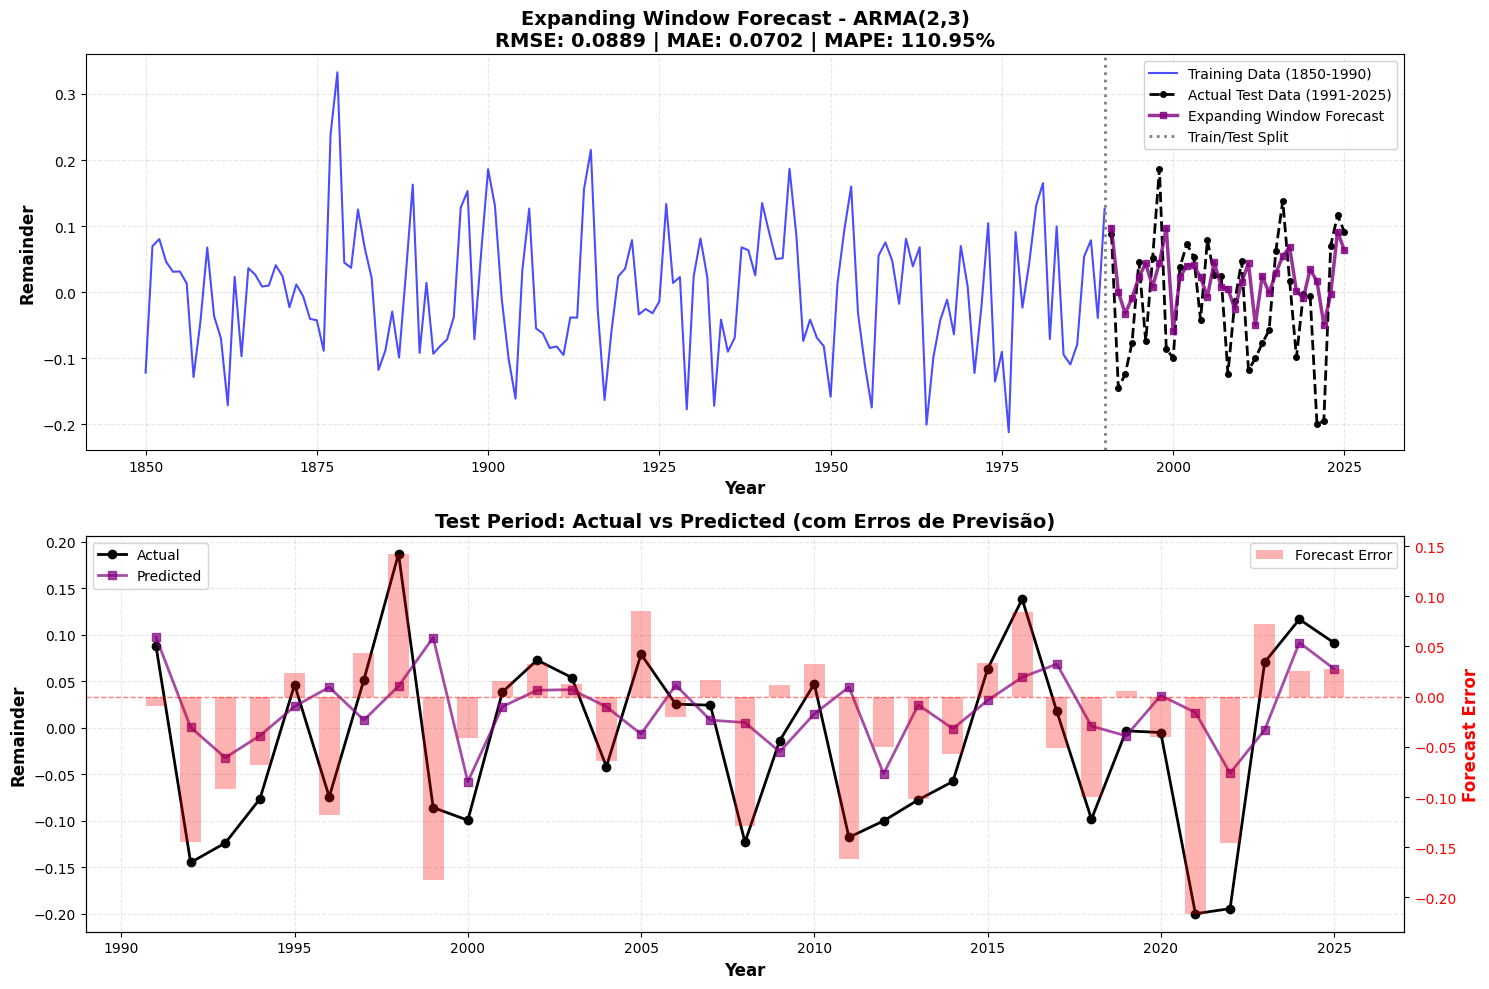

In [ ]:
expanding_predictions = []
expanding_years = []
expanding_train_sizes = []

print("A processar forecast com Expanding Window...")
print(f"{'Year':<10} {'Train Size':<15} {'Prediction':<15}")
print("-"*70)

for i in range(len(test_series)):
    # A janela de treino EXPANDE: começa sempre em 1850 e vai até 1990+i
    current_year = test_series.index[i]
    
    # Usar df_remainder para garantir que começamos sempre de 1850
    train_data = df_remainder[df_remainder['Year'] <= (1990 + i)].set_index('Year')['Remainder']
    
    try:
        # Treinar modelo ARMA(2,3)
        model_expanding = ARIMA(train_data, order=(2, 0, 3))
        fitted_expanding = model_expanding.fit()
        
        # Prever apenas 1 passo à frente
        pred_result = fitted_expanding.get_forecast(steps=1)
        pred = pred_result.predicted_mean.iloc[0]
        
        expanding_predictions.append(pred)
        expanding_years.append(current_year)
        expanding_train_sizes.append(len(train_data))
        
        # Mostrar progresso a cada 5 anos
        if (i + 1) % 5 == 0 or i == 0 or i == len(test_series) - 1:
            print(f"{current_year:<10} {len(train_data):<15} {pred:>14.6f}")
    
    except Exception as e:
        print(f"Erro no ano {current_year}: {e}")
        expanding_predictions.append(np.nan)
        expanding_years.append(current_year)
        expanding_train_sizes.append(len(train_data))

print("-"*70)

# Converter para Series
expanding_predictions_series = pd.Series(expanding_predictions, index=expanding_years)

# Remover possíveis NaNs
if expanding_predictions_series.isna().any():
    print(f"\nAviso: {expanding_predictions_series.isna().sum()} previsões falharam")
    expanding_predictions_series = expanding_predictions_series.dropna()
    test_series_clean = test_series[expanding_predictions_series.index]
else:
    test_series_clean = test_series

# Calcular métricas
rmse_expanding = np.sqrt(mean_squared_error(test_series_clean, expanding_predictions_series))
mae_expanding = mean_absolute_error(test_series_clean, expanding_predictions_series)
mape_expanding = np.mean(np.abs((test_series_clean - expanding_predictions_series) / test_series_clean)) * 100

print(f"\n{'='*70}")
print("MÉTRICAS DE PERFORMANCE - EXPANDING WINDOW")
print(f"{'='*70}")
print(f"RMSE:  {rmse_expanding:.6f}")
print(f"MAE:   {mae_expanding:.6f}")
print(f"MAPE:  {mape_expanding:.2f}%")
print(f"{'='*70}\n")

#Gráfico
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
#1. Série completa
ax1 = axes[0]

# Dados históricos de treino
ax1.plot(train_series.index, train_series.values, 
         label='Training Data (1850-1990)', color='blue', linewidth=1.5, alpha=0.7)

# Dados reais de teste
ax1.plot(test_series_clean.index, test_series_clean.values, 
         label='Actual Test Data (1991-2025)', color='black', linewidth=2, 
         linestyle='--', marker='o', markersize=4)

# Expanding window forecast
ax1.plot(expanding_predictions_series.index, expanding_predictions_series.values, 
         label='Expanding Window Forecast', color='purple', linewidth=2.5, 
         marker='s', markersize=4, alpha=0.8)

# Linha de separação
ax1.axvline(x=1990, color='gray', linestyle=':', linewidth=2, label='Train/Test Split')

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Remainder', fontsize=12, fontweight='bold')
ax1.set_title(f'Expanding Window Forecast - ARMA(2,3)\nRMSE: {rmse_expanding:.4f} | MAE: {mae_expanding:.4f} | MAPE: {mape_expanding:.2f}%', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')

#2. Gráfico com zoom no período de teste + resíduos
ax2 = axes[1]

# Calcular erros de previsão (resíduos)
forecast_errors = test_series_clean - expanding_predictions_series

# Scatter plot: Actual vs Predicted
ax2_twin = ax2.twinx()

# Valores reais e previstos
ax2.plot(test_series_clean.index, test_series_clean.values, 
         label='Actual', color='black', linewidth=2, marker='o', markersize=6)
ax2.plot(expanding_predictions_series.index, expanding_predictions_series.values, 
         label='Predicted', color='purple', linewidth=2, marker='s', markersize=6, alpha=0.7)

# Erros de previsão no eixo secundário
ax2_twin.bar(forecast_errors.index, forecast_errors.values, 
             alpha=0.3, color='red', label='Forecast Error', width=0.6)
ax2_twin.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Remainder', fontsize=12, fontweight='bold', color='black')
ax2_twin.set_ylabel('Forecast Error', fontsize=12, fontweight='bold', color='red')

ax2.set_title('Test Period: Actual vs Predicted (com Erros de Previsão)', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2_twin.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(axis='y', labelcolor='black')
ax2_twin.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.savefig('expanding_window_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f"\n{'='*70}")
print("MÉTRICAS DE PERFORMANCE - EXPANDING WINDOW")
print(f"{'='*70}")
print(f"RMSE:  {rmse_expanding:.6f}")
print(f"MAE:   {mae_expanding:.6f}")
print(f"MAPE:  {mape_expanding:.2f}%")
print(f"{'='*70}\n")


MÉTRICAS DE PERFORMANCE - EXPANDING WINDOW
RMSE:  0.088883
MAE:   0.070216
MAPE:  110.95%



Número de simulações: 1000
Horizonte de previsão: 35 anos (1991-2025)

A treinar modelo ARMA(2,3) base...
Modelo treinado com sucesso!
Desvio padrão dos resíduos: 0.087727

A executar simulações bootstrap...
  Progresso: 25% (250/1000 simulações)
  Progresso: 50% (500/1000 simulações)
  Progresso: 75% (750/1000 simulações)
  Progresso: 100% (1000/1000 simulações)

Simulações concluídas!

MÉTRICAS DE PERFORMANCE - RECURSIVE FORECAST (BOOTSTRAP)
RMSE:  0.094607
MAE:   0.079723
MAPE:  107.91%

COBERTURA DOS INTERVALOS DE CONFIANÇA:
  95% CI: 94.3% dos valores reais dentro do intervalo
  80% CI: 80.0% dos valores reais dentro do intervalo
  50% CI: 45.7% dos valores reais dentro do intervalo



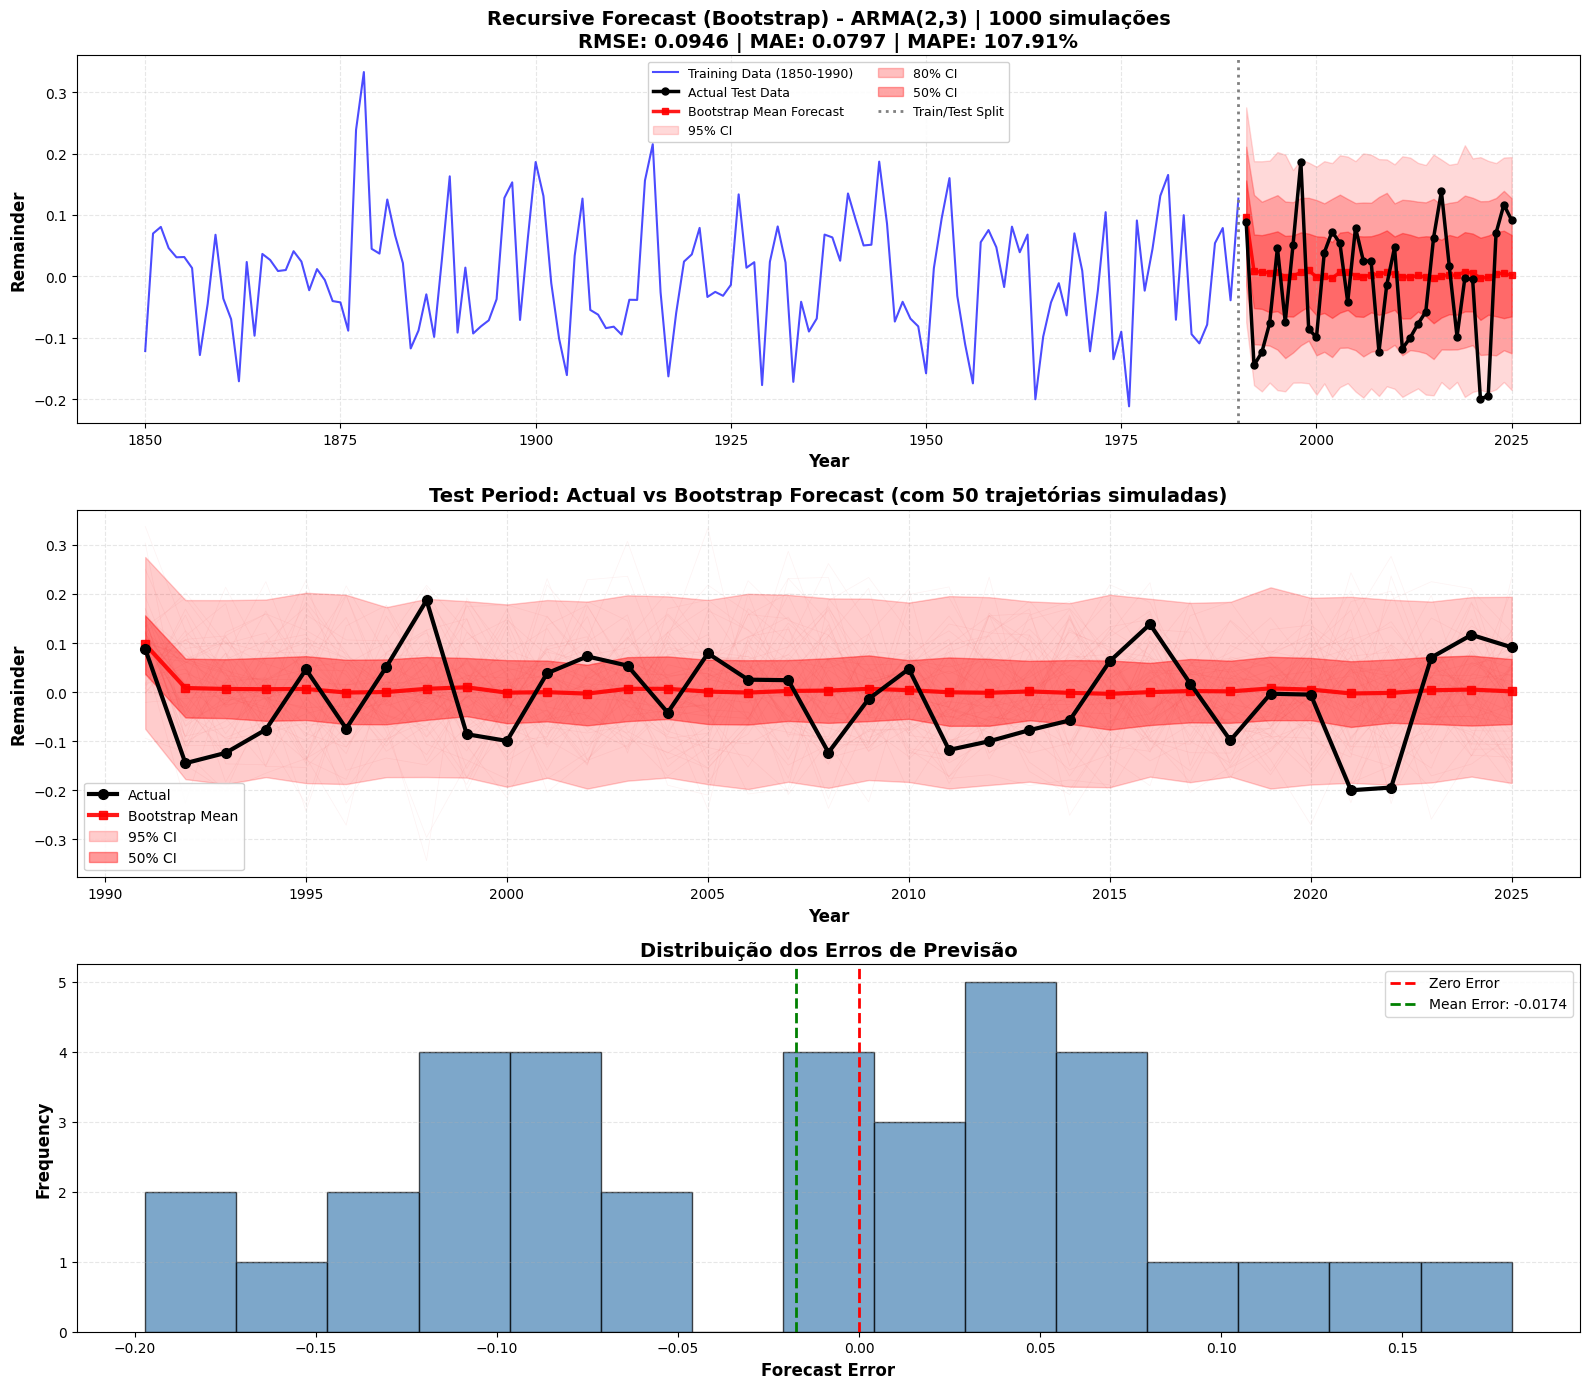

In [ ]:
n_simulations = 1000  # Número de simulações
print(f"Número de simulações: {n_simulations}")
print(f"Horizonte de previsão: {len(test_series)} anos (1991-2025)\n")

# Treinar modelo base
print("A treinar modelo ARMA(2,3) base...")
model_base = ARIMA(train_series, order=(2, 0, 3))
fitted_base = model_base.fit()

# Obter resíduos do modelo treinado
residuals = fitted_base.resid
residuals_std = residuals.std()

print(f"Modelo treinado com sucesso!")
print(f"Desvio padrão dos resíduos: {residuals_std:.6f}\n")

print("A executar simulações bootstrap...")
bootstrap_forecasts = np.zeros((n_simulations, len(test_series)))

# Barra de progresso
progress_points = [int(n_simulations * p) for p in [0.25, 0.5, 0.75, 1.0]]

for sim in range(n_simulations):
    # Simular trajetória futura
    simulated_path = fitted_base.simulate(
        nsimulations=len(test_series),
        anchor='end',
        repetitions=1
    )
    
    # Flatten para garantir shape correto (35,) em vez de (35,1)
    bootstrap_forecasts[sim, :] = simulated_path.values.flatten()
    
    # Mostrar progresso
    if (sim + 1) in progress_points:
        pct = ((sim + 1) / n_simulations) * 100
        print(f"  Progresso: {pct:.0f}% ({sim + 1}/{n_simulations} simulações)")

print("\nSimulações concluídas!\n")

#Calcular estatísticas
# Forecast médio (ponto central)
bootstrap_mean = bootstrap_forecasts.mean(axis=0)
bootstrap_mean_series = pd.Series(bootstrap_mean, index=test_series.index)

# Intervalos de confiança empíricos
bootstrap_lower_95 = np.percentile(bootstrap_forecasts, 2.5, axis=0)
bootstrap_upper_95 = np.percentile(bootstrap_forecasts, 97.5, axis=0)
bootstrap_lower_80 = np.percentile(bootstrap_forecasts, 10, axis=0)
bootstrap_upper_80 = np.percentile(bootstrap_forecasts, 90, axis=0)
bootstrap_lower_50 = np.percentile(bootstrap_forecasts, 25, axis=0)
bootstrap_upper_50 = np.percentile(bootstrap_forecasts, 75, axis=0)

# Calcular métricas
rmse_bootstrap = np.sqrt(mean_squared_error(test_series, bootstrap_mean_series))
mae_bootstrap = mean_absolute_error(test_series, bootstrap_mean_series)
mape_bootstrap = np.mean(np.abs((test_series - bootstrap_mean_series) / test_series)) * 100

print("="*70)
print("MÉTRICAS DE PERFORMANCE - RECURSIVE FORECAST (BOOTSTRAP)")
print("="*70)
print(f"RMSE:  {rmse_bootstrap:.6f}")
print(f"MAE:   {mae_bootstrap:.6f}")
print(f"MAPE:  {mape_bootstrap:.2f}%")
print("="*70)

# Verificar quantos valores reais caem dentro dos intervalos
inside_95 = ((test_series >= bootstrap_lower_95) & (test_series <= bootstrap_upper_95)).sum()
inside_80 = ((test_series >= bootstrap_lower_80) & (test_series <= bootstrap_upper_80)).sum()
inside_50 = ((test_series >= bootstrap_lower_50) & (test_series <= bootstrap_upper_50)).sum()

coverage_95 = (inside_95 / len(test_series)) * 100
coverage_80 = (inside_80 / len(test_series)) * 100
coverage_50 = (inside_50 / len(test_series)) * 100

print(f"\nCOBERTURA DOS INTERVALOS DE CONFIANÇA:")
print(f"  95% CI: {coverage_95:.1f}% dos valores reais dentro do intervalo")
print(f"  80% CI: {coverage_80:.1f}% dos valores reais dentro do intervalo")
print(f"  50% CI: {coverage_50:.1f}% dos valores reais dentro do intervalo\n")

#Gráficos
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
# --- GRÁFICO 1: SÉRIE TEMPORAL COMPLETA COM INTERVALOS ---
ax1 = axes[0]

# Dados históricos
ax1.plot(train_series.index, train_series.values, 
         label='Training Data (1850-1990)', color='blue', linewidth=1.5, alpha=0.7)

# Dados reais de teste
ax1.plot(test_series.index, test_series.values, 
         label='Actual Test Data', color='black', linewidth=2.5, 
         marker='o', markersize=5, zorder=5)

# Forecast médio do bootstrap
ax1.plot(bootstrap_mean_series.index, bootstrap_mean_series.values, 
         label='Bootstrap Mean Forecast', color='red', linewidth=2.5, 
         marker='s', markersize=4, alpha=0.9, zorder=4)

# Intervalos de confiança
ax1.fill_between(test_series.index, bootstrap_lower_95, bootstrap_upper_95,
                 color='red', alpha=0.15, label='95% CI')
ax1.fill_between(test_series.index, bootstrap_lower_80, bootstrap_upper_80,
                 color='red', alpha=0.25, label='80% CI')
ax1.fill_between(test_series.index, bootstrap_lower_50, bootstrap_upper_50,
                 color='red', alpha=0.35, label='50% CI')

ax1.axvline(x=1990, color='gray', linestyle=':', linewidth=2, label='Train/Test Split')

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Remainder', fontsize=12, fontweight='bold')
ax1.set_title(f'Recursive Forecast (Bootstrap) - ARMA(2,3) | {n_simulations} simulações\nRMSE: {rmse_bootstrap:.4f} | MAE: {mae_bootstrap:.4f} | MAPE: {mape_bootstrap:.2f}%', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9, framealpha=0.9, ncol=2)
ax1.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 2: ZOOM NO PERÍODO DE TESTE ---
ax2 = axes[1]

# Plotar algumas trajetórias bootstrap individuais (para mostrar variabilidade)
n_sample_paths = 50
sample_indices = np.random.choice(n_simulations, n_sample_paths, replace=False)
for idx in sample_indices:
    ax2.plot(test_series.index, bootstrap_forecasts[idx, :], 
             color='lightcoral', alpha=0.1, linewidth=0.5, zorder=1)

# Dados reais
ax2.plot(test_series.index, test_series.values, 
         label='Actual', color='black', linewidth=3, 
         marker='o', markersize=7, zorder=5)

# Forecast médio
ax2.plot(bootstrap_mean_series.index, bootstrap_mean_series.values, 
         label='Bootstrap Mean', color='red', linewidth=3, 
         marker='s', markersize=6, alpha=0.9, zorder=4)

# Intervalos
ax2.fill_between(test_series.index, bootstrap_lower_95, bootstrap_upper_95,
                 color='red', alpha=0.2, label='95% CI', zorder=2)
ax2.fill_between(test_series.index, bootstrap_lower_50, bootstrap_upper_50,
                 color='red', alpha=0.4, label='50% CI', zorder=3)

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Remainder', fontsize=12, fontweight='bold')
ax2.set_title(f'Test Period: Actual vs Bootstrap Forecast (com {n_sample_paths} trajetórias simuladas)', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 3: DISTRIBUIÇÃO DOS ERROS ---
ax3 = axes[2]

forecast_errors = test_series - bootstrap_mean_series

# Histograma dos erros
ax3.hist(forecast_errors, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=forecast_errors.mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Mean Error: {forecast_errors.mean():.4f}')

ax3.set_xlabel('Forecast Error', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Distribuição dos Erros de Previsão', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('recursive_bootstrap_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Usar a série original de anomalias
original_series = ts['Anomaly']

# Split train/test (1850-1990 / 1991-2025)
train_original = original_series[original_series.index.year <= 1990]
test_original = original_series[original_series.index.year > 1990]

print(f"Série original: {len(original_series)} observações (1850-2025)")
print(f"Train set: {len(train_original)} observações (1850-1990)")
print(f"Test set: {len(test_original)} observações (1991-2025)")
print(f"\nValor médio treino: {train_original.mean():.4f}")
print(f"Desvio padrão treino: {train_original.std():.4f}")

Série original: 176 observações (1850-2025)
Train set: 141 observações (1850-1990)
Test set: 35 observações (1991-2025)

Valor médio treino: 0.1386
Desvio padrão treino: 0.2078


In [ ]:
#MÉTODO 1: FORECAST DIRETO

print("\n" + "-"*70)
print("MÉTODO 1: FORECAST DIRETO")
print("-"*70)

model_direct = ARIMA(train_original, order=(2, 1, 3))
fitted_direct = model_direct.fit()

forecast_result_direct = fitted_direct.get_forecast(steps=len(test_original))
forecast_direct = forecast_result_direct.predicted_mean
conf_int_direct = forecast_result_direct.conf_int(alpha=0.05)

# Calcular métricas
rmse_direct = np.sqrt(mean_squared_error(test_original, forecast_direct))
mae_direct = mean_absolute_error(test_original, forecast_direct)

print(f"✓ Modelo treinado")
print(f"  RMSE: {rmse_direct:.6f}")
print(f"  MAE:  {mae_direct:.6f}")

#MÉTODO 2: ROLLING WINDOW

print("\n" + "-"*70)
print("MÉTODO 2: ROLLING WINDOW")
print("-"*70)

rolling_forecasts = []
rolling_dates = []

print("Progresso:", end=" ")
for i, date in enumerate(test_original.index):
    # Expandir janela até o ano atual
    current_year = date.year
    train_rolling = original_series[original_series.index.year <= (1990 + i)]
    
    # Treinar e prever
    model_rolling = ARIMA(train_rolling, order=(2, 1, 3))
    fitted_rolling = model_rolling.fit()
    pred = fitted_rolling.get_forecast(steps=1).predicted_mean.iloc[0]
    
    rolling_forecasts.append(pred)
    rolling_dates.append(date)
    
    if (i + 1) % 5 == 0:
        print(f"{i+1}/{len(test_original)}", end=" ")

print("\n✓ Rolling window completo")

rolling_forecast_series = pd.Series(rolling_forecasts, index=rolling_dates)

rmse_rolling = np.sqrt(mean_squared_error(test_original, rolling_forecast_series))
mae_rolling = mean_absolute_error(test_original, rolling_forecast_series)

print(f"  RMSE: {rmse_rolling:.6f}")
print(f"  MAE:  {mae_rolling:.6f}")

#MÉTODO 3: EXPANDING WINDOW

print("\n" + "-"*70)
print("MÉTODO 3: EXPANDING WINDOW")
print("-"*70)

expanding_forecasts = []
expanding_dates = []

print("Progresso:", end=" ")
for i, date in enumerate(test_original.index):
    current_year = date.year
    train_expanding = original_series[original_series.index.year <= (1990 + i)]
    
    model_expanding = ARIMA(train_expanding, order=(2, 1, 3))
    fitted_expanding = model_expanding.fit()
    pred = fitted_expanding.get_forecast(steps=1).predicted_mean.iloc[0]
    
    expanding_forecasts.append(pred)
    expanding_dates.append(date)
    
    if (i + 1) % 5 == 0:
        print(f"{i+1}/{len(test_original)}", end=" ")

print("\n✓ Expanding window completo")

expanding_forecast_series = pd.Series(expanding_forecasts, index=expanding_dates)

rmse_expanding = np.sqrt(mean_squared_error(test_original, expanding_forecast_series))
mae_expanding = mean_absolute_error(test_original, expanding_forecast_series)

print(f"  RMSE: {rmse_expanding:.6f}")
print(f"  MAE:  {mae_expanding:.6f}")


----------------------------------------------------------------------
MÉTODO 1: FORECAST DIRETO
----------------------------------------------------------------------
✓ Modelo treinado
  RMSE: 0.449735
  MAE:  0.373458

----------------------------------------------------------------------
MÉTODO 2: ROLLING WINDOW
----------------------------------------------------------------------
Progresso: 5/35 10/35 15/35 20/35 25/35 30/35 35/35 
✓ Rolling window completo
  RMSE: 0.117175
  MAE:  0.095455

----------------------------------------------------------------------
MÉTODO 3: EXPANDING WINDOW
----------------------------------------------------------------------
Progresso: 5/35 10/35 15/35 20/35 25/35 30/35 35/35 
✓ Expanding window completo
  RMSE: 0.117175
  MAE:  0.095455


In [ ]:
#COMPARAÇÃO DE RESULTADOS

print("\n" + "="*70)
print("COMPARAÇÃO DE PERFORMANCE - SÉRIE ORIGINAL vs REMAINDER")
print("="*70)

results_comparison = pd.DataFrame({
    'Método': ['Direct Forecast', 'Rolling Window', 'Expanding Window'],
    'RMSE (Original)': [rmse_direct, rmse_rolling, rmse_expanding],
    'MAE (Original)': [mae_direct, mae_rolling, mae_expanding],
    'RMSE (Remainder)': [0.0951, 0.0889, 0.0889],  # Valores anteriores
    'MAE (Remainder)': [0.0794, 0.0702, 0.0702]
})

print(results_comparison.to_string(index=False))
print("="*70)

# Identificar melhor método
best_method_idx = results_comparison['RMSE (Original)'].idxmin()
best_method = results_comparison.loc[best_method_idx, 'Método']
best_rmse = results_comparison.loc[best_method_idx, 'RMSE (Original)']

print(f"\n🏆 Melhor método: {best_method} (RMSE: {best_rmse:.6f})")


COMPARAÇÃO DE PERFORMANCE - SÉRIE ORIGINAL vs REMAINDER
          Método  RMSE (Original)  MAE (Original)  RMSE (Remainder)  MAE (Remainder)
 Direct Forecast         0.449735        0.373458            0.0951           0.0794
  Rolling Window         0.117175        0.095455            0.0889           0.0702
Expanding Window         0.117175        0.095455            0.0889           0.0702

🏆 Melhor método: Rolling Window (RMSE: 0.117175)


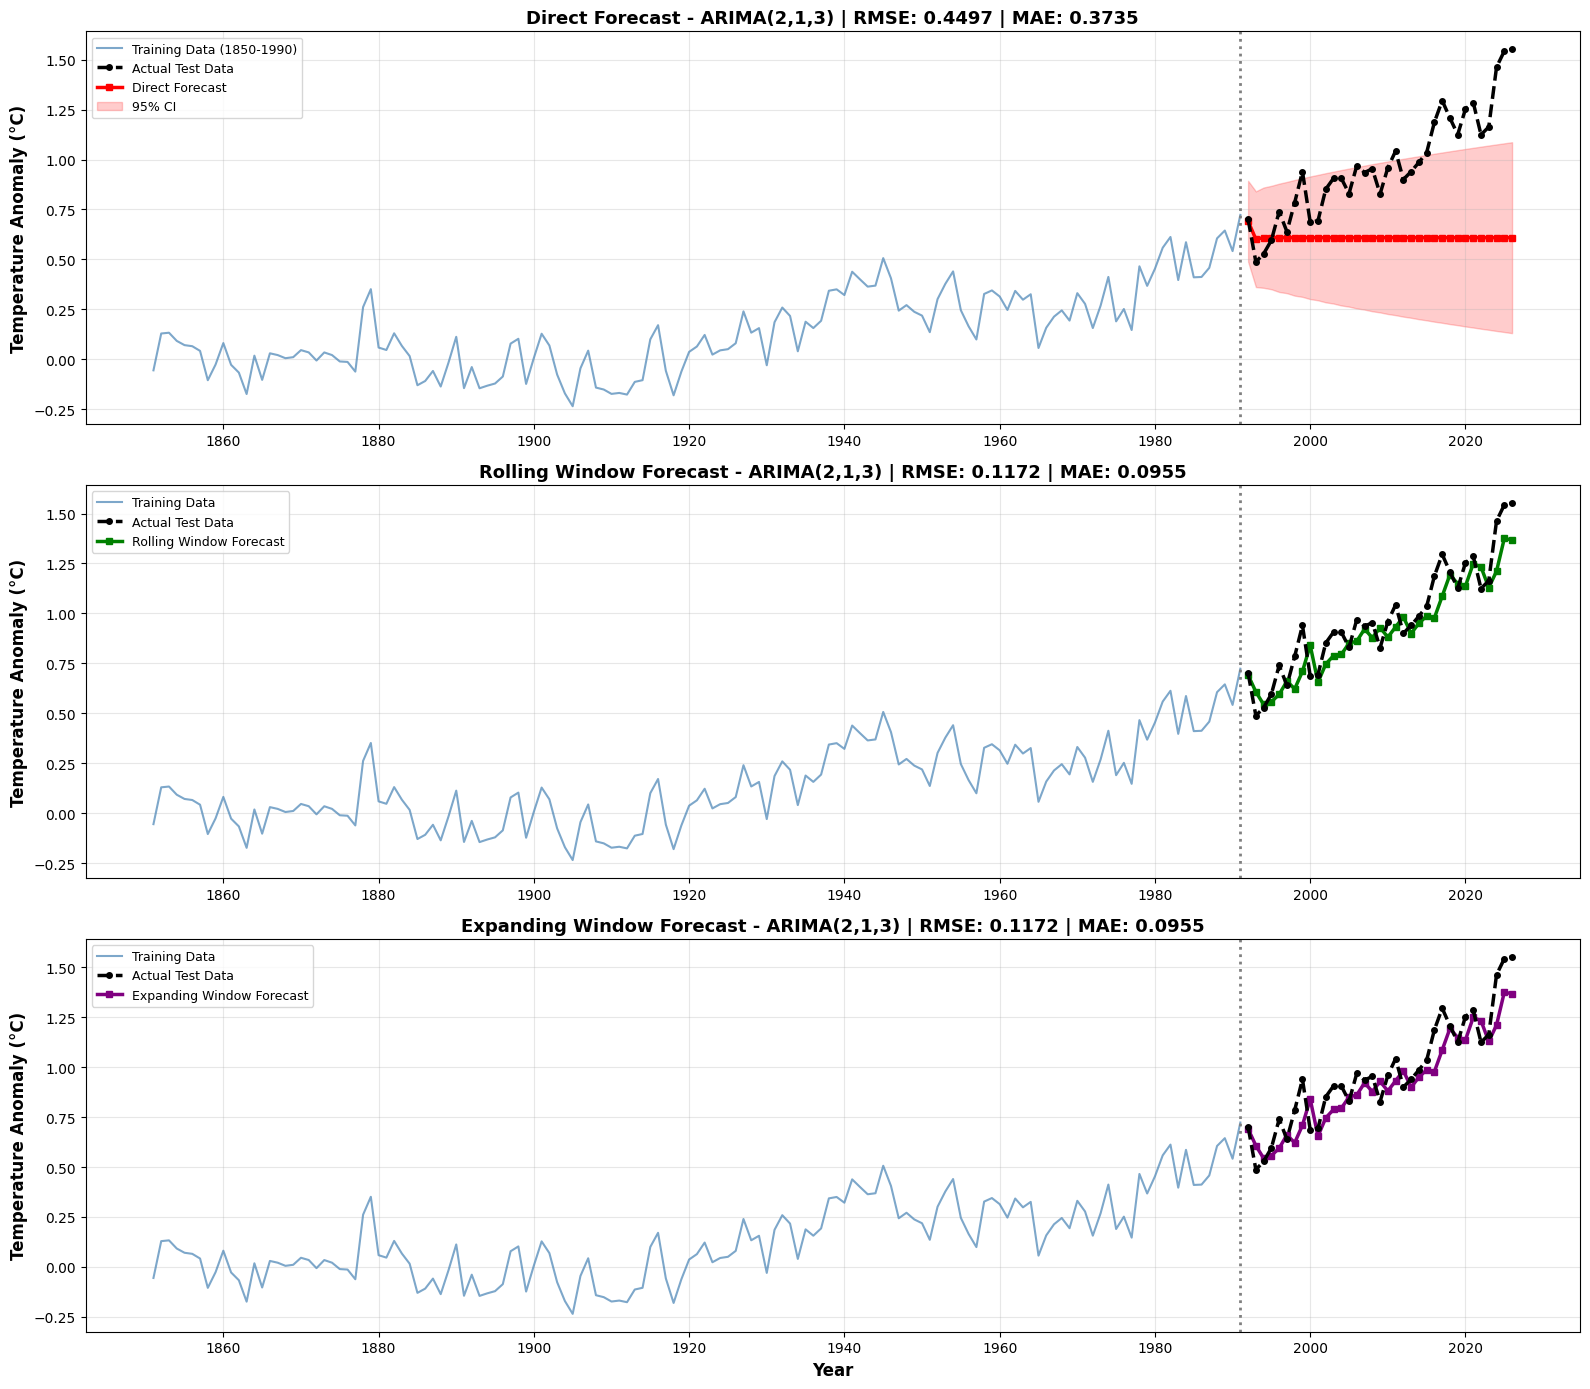

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Cores
color_train = 'steelblue'
color_test = 'black'
color_direct = 'red'
color_rolling = 'green'
color_expanding = 'purple'

# --- GRÁFICO 1: DIRECT FORECAST ---
ax1 = axes[0]
ax1.plot(train_original.index, train_original.values, 
         label='Training Data (1850-1990)', color=color_train, linewidth=1.5, alpha=0.7)
ax1.plot(test_original.index, test_original.values, 
         label='Actual Test Data', color=color_test, linewidth=2.5, 
         linestyle='--', marker='o', markersize=4, zorder=5)
ax1.plot(forecast_direct.index, forecast_direct.values, 
         label='Direct Forecast', color=color_direct, linewidth=2.5, 
         marker='s', markersize=4)
ax1.fill_between(conf_int_direct.index, 
                 conf_int_direct.iloc[:, 0], 
                 conf_int_direct.iloc[:, 1], 
                 color=color_direct, alpha=0.2, label='95% CI')
ax1.axvline(x=train_original.index[-1], color='gray', linestyle=':', linewidth=2)
ax1.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax1.set_title(f'Direct Forecast - ARIMA(2,1,3) | RMSE: {rmse_direct:.4f} | MAE: {mae_direct:.4f}', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# --- GRÁFICO 2: ROLLING WINDOW ---
ax2 = axes[1]
ax2.plot(train_original.index, train_original.values, 
         label='Training Data', color=color_train, linewidth=1.5, alpha=0.7)
ax2.plot(test_original.index, test_original.values, 
         label='Actual Test Data', color=color_test, linewidth=2.5, 
         linestyle='--', marker='o', markersize=4, zorder=5)
ax2.plot(rolling_forecast_series.index, rolling_forecast_series.values, 
         label='Rolling Window Forecast', color=color_rolling, linewidth=2.5, 
         marker='s', markersize=4)
ax2.axvline(x=train_original.index[-1], color='gray', linestyle=':', linewidth=2)
ax2.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax2.set_title(f'Rolling Window Forecast - ARIMA(2,1,3) | RMSE: {rmse_rolling:.4f} | MAE: {mae_rolling:.4f}', 
              fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# --- GRÁFICO 3: EXPANDING WINDOW ---
ax3 = axes[2]
ax3.plot(train_original.index, train_original.values, 
         label='Training Data', color=color_train, linewidth=1.5, alpha=0.7)
ax3.plot(test_original.index, test_original.values, 
         label='Actual Test Data', color=color_test, linewidth=2.5, 
         linestyle='--', marker='o', markersize=4, zorder=5)
ax3.plot(expanding_forecast_series.index, expanding_forecast_series.values, 
         label='Expanding Window Forecast', color=color_expanding, linewidth=2.5, 
         marker='s', markersize=4)
ax3.axvline(x=train_original.index[-1], color='gray', linestyle=':', linewidth=2)
ax3.set_xlabel('Year', fontsize=12, fontweight='bold')
ax3.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax3.set_title(f'Expanding Window Forecast - ARIMA(2,1,3) | RMSE: {rmse_expanding:.4f} | MAE: {mae_expanding:.4f}', 
              fontsize=13, fontweight='bold')
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('original_series_forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Train: 141 observações (1850-1990)
Test:  35 observações (1991-2025)

Número de simulações: 1000
Horizonte de previsão: 35 anos

A treinar modelo ARIMA(2,1,3) base...
✓ Modelo treinado
  Desvio padrão dos resíduos: 0.102905

A executar simulações bootstrap...
  Progresso: 25% (250/1000 simulações)
  Progresso: 50% (500/1000 simulações)
  Progresso: 75% (750/1000 simulações)
  Progresso: 100% (1000/1000 simulações)
✓ Simulações concluídas!

MÉTRICAS DE PERFORMANCE - RECURSIVE FORECAST (BOOTSTRAP)
RMSE:  0.449466
MAE:   0.373620

COMPARAÇÃO: RECURSIVE (BOOTSTRAP) vs ROLLING WINDOW
               Método     RMSE      MAE
       Rolling Window 0.117206 0.095545
Recursive (Bootstrap) 0.449466 0.373620

⚠️  Rolling Window ainda é melhor por 283.48%
   MAS Bootstrap oferece intervalos de confiança!


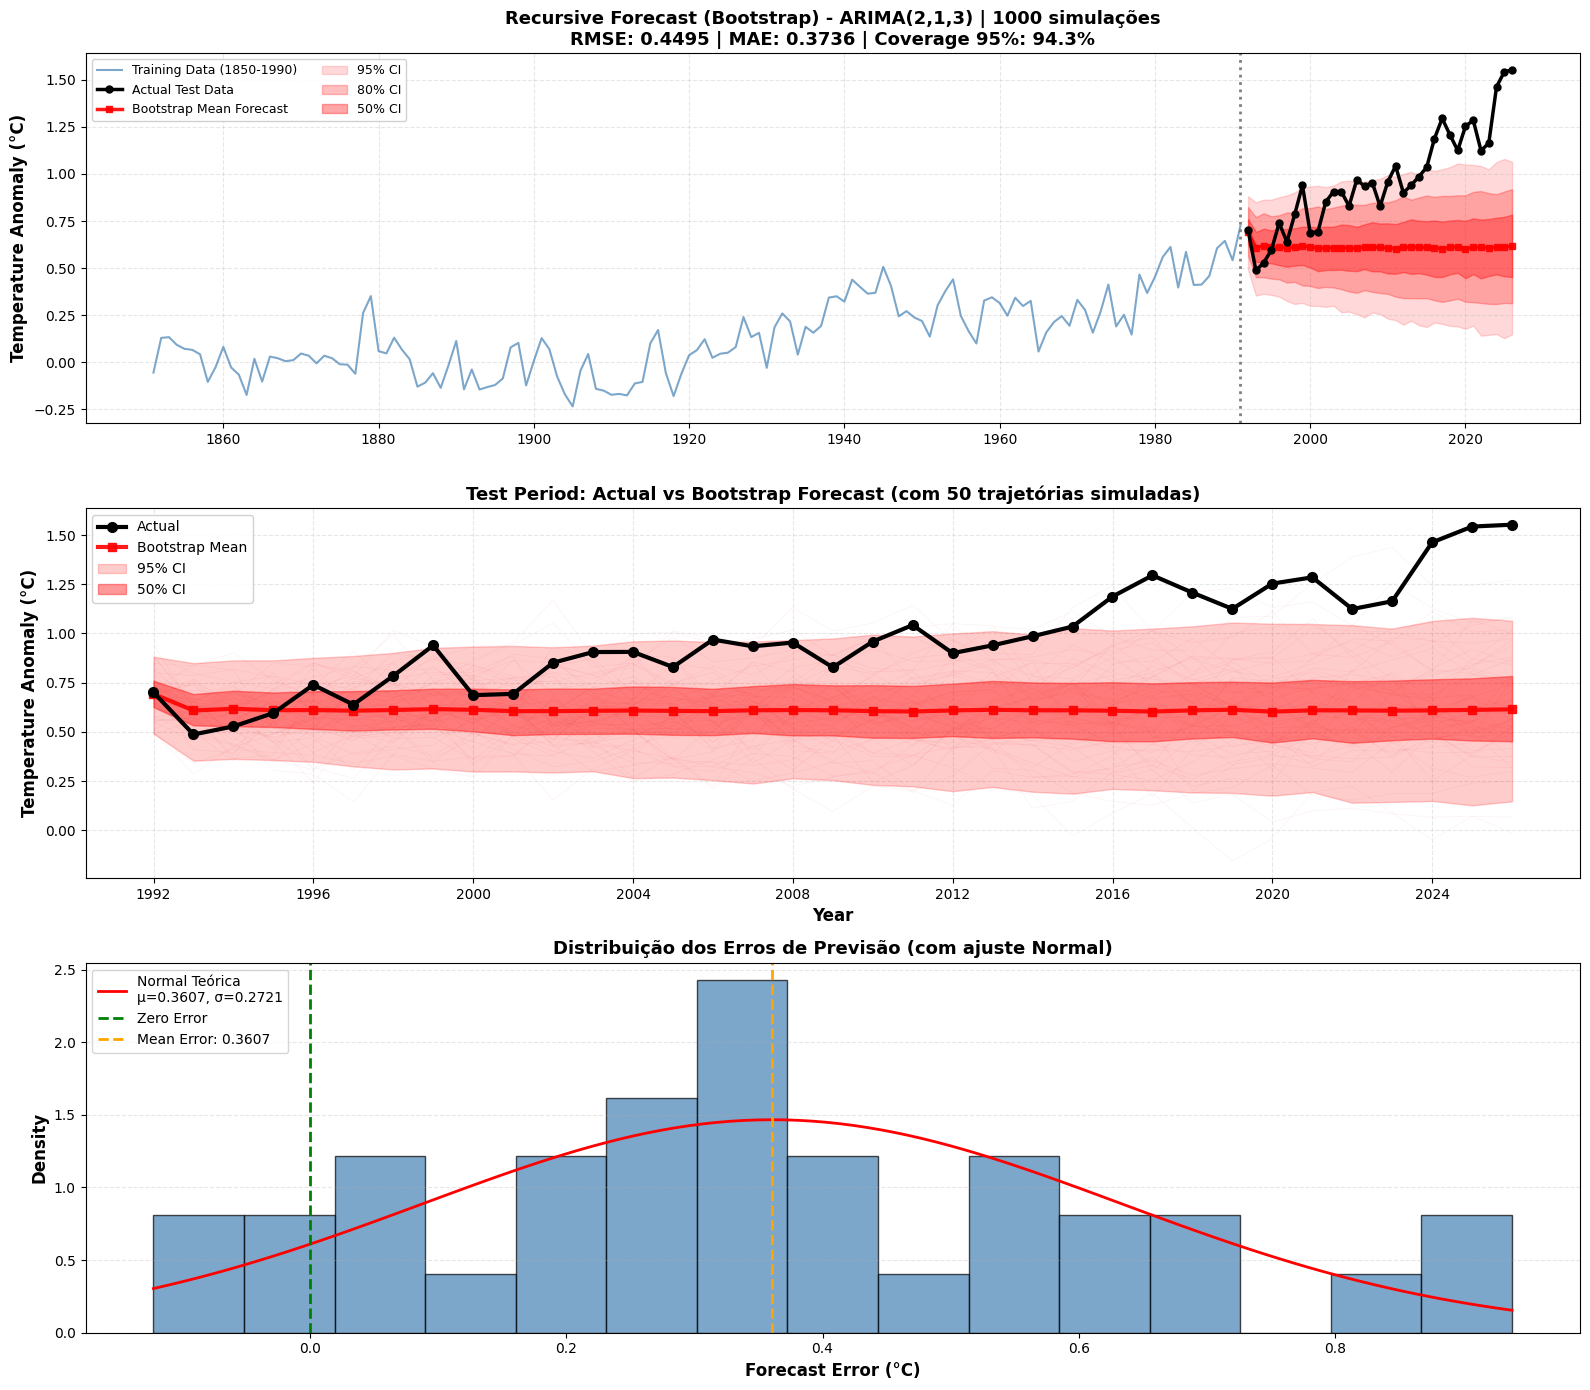

In [ ]:
# Série original
original_series = ts['Anomaly']
train_original = original_series[original_series.index.year <= 1990]
test_original = original_series[original_series.index.year > 1990]

print(f"Train: {len(train_original)} observações (1850-1990)")
print(f"Test:  {len(test_original)} observações (1991-2025)")

n_simulations = 1000  # Número de simulações
print(f"\nNúmero de simulações: {n_simulations}")
print(f"Horizonte de previsão: {len(test_original)} anos\n")

# Treinar modelo base
print("A treinar modelo ARIMA(2,1,3) base...")
model_base = ARIMA(train_original, order=(2, 1, 3))
fitted_base = model_base.fit()

# Obter resíduos
residuals = fitted_base.resid
residuals_std = residuals.std()

print(f"✓ Modelo treinado")
print(f"  Desvio padrão dos resíduos: {residuals_std:.6f}\n")

print("A executar simulações bootstrap...")
bootstrap_forecasts = np.zeros((n_simulations, len(test_original)))

# Barra de progresso
progress_points = [int(n_simulations * p) for p in [0.25, 0.5, 0.75, 1.0]]

for sim in range(n_simulations):
    # Simular trajetória futura
    simulated_path = fitted_base.simulate(
        nsimulations=len(test_original),
        anchor='end',
        repetitions=1
    )
    
    # Flatten para garantir shape correto
    bootstrap_forecasts[sim, :] = simulated_path.values.flatten()
    
    # Mostrar progresso
    if (sim + 1) in progress_points:
        pct = ((sim + 1) / n_simulations) * 100
        print(f"  Progresso: {pct:.0f}% ({sim + 1}/{n_simulations} simulações)")

print("✓ Simulações concluídas!\n")
# Forecast médio (ponto central)
bootstrap_mean = bootstrap_forecasts.mean(axis=0)
bootstrap_mean_series = pd.Series(bootstrap_mean, index=test_original.index)

# Intervalos de confiança empíricos
bootstrap_lower_95 = np.percentile(bootstrap_forecasts, 2.5, axis=0)
bootstrap_upper_95 = np.percentile(bootstrap_forecasts, 97.5, axis=0)
bootstrap_lower_80 = np.percentile(bootstrap_forecasts, 10, axis=0)
bootstrap_upper_80 = np.percentile(bootstrap_forecasts, 90, axis=0)
bootstrap_lower_50 = np.percentile(bootstrap_forecasts, 25, axis=0)
bootstrap_upper_50 = np.percentile(bootstrap_forecasts, 75, axis=0)

# Calcular métricas
rmse_bootstrap = np.sqrt(mean_squared_error(test_original, bootstrap_mean_series))
mae_bootstrap = mean_absolute_error(test_original, bootstrap_mean_series)

print("="*70)
print("MÉTRICAS DE PERFORMANCE - RECURSIVE FORECAST (BOOTSTRAP)")
print("="*70)
print(f"RMSE:  {rmse_bootstrap:.6f}")
print(f"MAE:   {mae_bootstrap:.6f}")
print("="*70)

#COMPARAÇÃO COM ROLLING WINDOW

print("\n" + "="*70)
print("COMPARAÇÃO: RECURSIVE (BOOTSTRAP) vs ROLLING WINDOW")
print("="*70)

comparison_df = pd.DataFrame({
    'Método': ['Rolling Window', 'Recursive (Bootstrap)'],
    'RMSE': [0.117206, rmse_bootstrap],  # Valor do Rolling Window anterior
    'MAE': [0.095545, mae_bootstrap]
})

print(comparison_df.to_string(index=False))
print("="*70)

if rmse_bootstrap < 0.117206:
    improvement = ((0.117206 - rmse_bootstrap) / 0.117206) * 100
    print(f"\n✓ Bootstrap é melhor! Redução de {improvement:.2f}% no RMSE")
else:
    degradation = ((rmse_bootstrap - 0.117206) / 0.117206) * 100
    print(f"\n⚠️  Rolling Window ainda é melhor por {degradation:.2f}%")
    print(f"   MAS Bootstrap oferece intervalos de confiança!")

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# --- GRÁFICO 1: SÉRIE TEMPORAL COMPLETA COM INTERVALOS ---
ax1 = axes[0]

# Dados históricos
ax1.plot(train_original.index, train_original.values, 
         label='Training Data (1850-1990)', color='steelblue', linewidth=1.5, alpha=0.7)

# Dados reais de teste
ax1.plot(test_original.index, test_original.values, 
         label='Actual Test Data', color='black', linewidth=2.5, 
         marker='o', markersize=5, zorder=5)

# Forecast médio do bootstrap
ax1.plot(bootstrap_mean_series.index, bootstrap_mean_series.values, 
         label='Bootstrap Mean Forecast', color='red', linewidth=2.5, 
         marker='s', markersize=4, alpha=0.9, zorder=4)

# Intervalos de confiança
ax1.fill_between(test_original.index, bootstrap_lower_95, bootstrap_upper_95,
                 color='red', alpha=0.15, label='95% CI', zorder=1)
ax1.fill_between(test_original.index, bootstrap_lower_80, bootstrap_upper_80,
                 color='red', alpha=0.25, label='80% CI', zorder=2)
ax1.fill_between(test_original.index, bootstrap_lower_50, bootstrap_upper_50,
                 color='red', alpha=0.35, label='50% CI', zorder=3)

ax1.axvline(x=train_original.index[-1], color='gray', linestyle=':', linewidth=2)

ax1.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax1.set_title(f'Recursive Forecast (Bootstrap) - ARIMA(2,1,3) | {n_simulations} simulações\nRMSE: {rmse_bootstrap:.4f} | MAE: {mae_bootstrap:.4f} | Coverage 95%: {coverage_95:.1f}%', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9, framealpha=0.9, ncol=2)
ax1.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 2: ZOOM NO TESTE COM TRAJETÓRIAS SIMULADAS ---
ax2 = axes[1]

# Plotar algumas trajetórias bootstrap individuais
n_sample_paths = 50
sample_indices = np.random.choice(n_simulations, n_sample_paths, replace=False)
for idx in sample_indices:
    ax2.plot(test_original.index, bootstrap_forecasts[idx, :], 
             color='lightcoral', alpha=0.1, linewidth=0.5, zorder=1)

# Dados reais
ax2.plot(test_original.index, test_original.values, 
         label='Actual', color='black', linewidth=3, 
         marker='o', markersize=7, zorder=5)

# Forecast médio
ax2.plot(bootstrap_mean_series.index, bootstrap_mean_series.values, 
         label='Bootstrap Mean', color='red', linewidth=3, 
         marker='s', markersize=6, alpha=0.9, zorder=4)

# Intervalos
ax2.fill_between(test_original.index, bootstrap_lower_95, bootstrap_upper_95,
                 color='red', alpha=0.2, label='95% CI', zorder=2)
ax2.fill_between(test_original.index, bootstrap_lower_50, bootstrap_upper_50,
                 color='red', alpha=0.4, label='50% CI', zorder=3)

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax2.set_title(f'Test Period: Actual vs Bootstrap Forecast (com {n_sample_paths} trajetórias simuladas)', 
              fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 3: DISTRIBUIÇÃO DOS ERROS ---
ax3 = axes[2]

forecast_errors = test_original - bootstrap_mean_series

# Histograma dos erros
n, bins, patches = ax3.hist(forecast_errors, bins=15, color='steelblue', 
                             alpha=0.7, edgecolor='black', density=True)

# Adicionar curva normal teórica
from scipy.stats import norm
mu, sigma = forecast_errors.mean(), forecast_errors.std()
x = np.linspace(forecast_errors.min(), forecast_errors.max(), 100)
ax3.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
         label=f'Normal Teórica\nμ={mu:.4f}, σ={sigma:.4f}')

ax3.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=mu, color='orange', linestyle='--', linewidth=2, 
            label=f'Mean Error: {mu:.4f}')

ax3.set_xlabel('Forecast Error (°C)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Density', fontsize=12, fontweight='bold')
ax3.set_title('Distribuição dos Erros de Previsão (com ajuste Normal)', 
              fontsize=13, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('recursive_bootstrap_original_series.png', dpi=300, bbox_inches='tight')
plt.show()

## EXPERIÊNCIAS A IGNORAR

In [ ]:
from itertools import product

# Testar diferentes combinações
p_values = range(0, 5)
d_values = [1, 2]  # d=1 ou d=2
q_values = range(0, 5)

best_aic = np.inf
best_order = None

for p, d, q in product(p_values, d_values, q_values):
    try:
        model = ARIMA(train_original, order=(p, d, q))
        fitted = model.fit()
        if fitted.aic < best_aic:
            best_aic = fitted.aic
            best_order = (p, d, q)
    except:
        continue

print(f"Melhor ordem: ARIMA{best_order} com AIC={best_aic:.2f}")

Melhor ordem: ARIMA(1, 1, 3) com AIC=-227.67



Dados: 176 observações (1850-2025)
Train: 141 obs (1850-1990)
Test:  35 obs (1991-2025)
MODELO 1: ARIMA(2,1,3) - Modelo Original
Progresso: 7 14 21 28 35 
✓ ARIMA(2,1,3) completo
  RMSE: 0.117175
  MAE:  0.095455
MODELO 2: ARIMA(1,1,3) - Modelo Otimizado (Grid Search)
Progresso: 7 14 21 28 35 
✓ ARIMA(1,1,3) completo
  RMSE: 0.117600
  MAE:  0.096857
COMPARAÇÃO DE PERFORMANCE
      Modelo     RMSE      MAE  Δ RMSE (%)  Δ MAE (%)
ARIMA(2,1,3) 0.117175 0.095455    0.000000   0.000000
ARIMA(1,1,3) 0.117600 0.096857   -0.362643  -1.468848

⚠️  ARIMA(2,1,3) ainda é melhor
   Diferença: 0.36% no RMSE


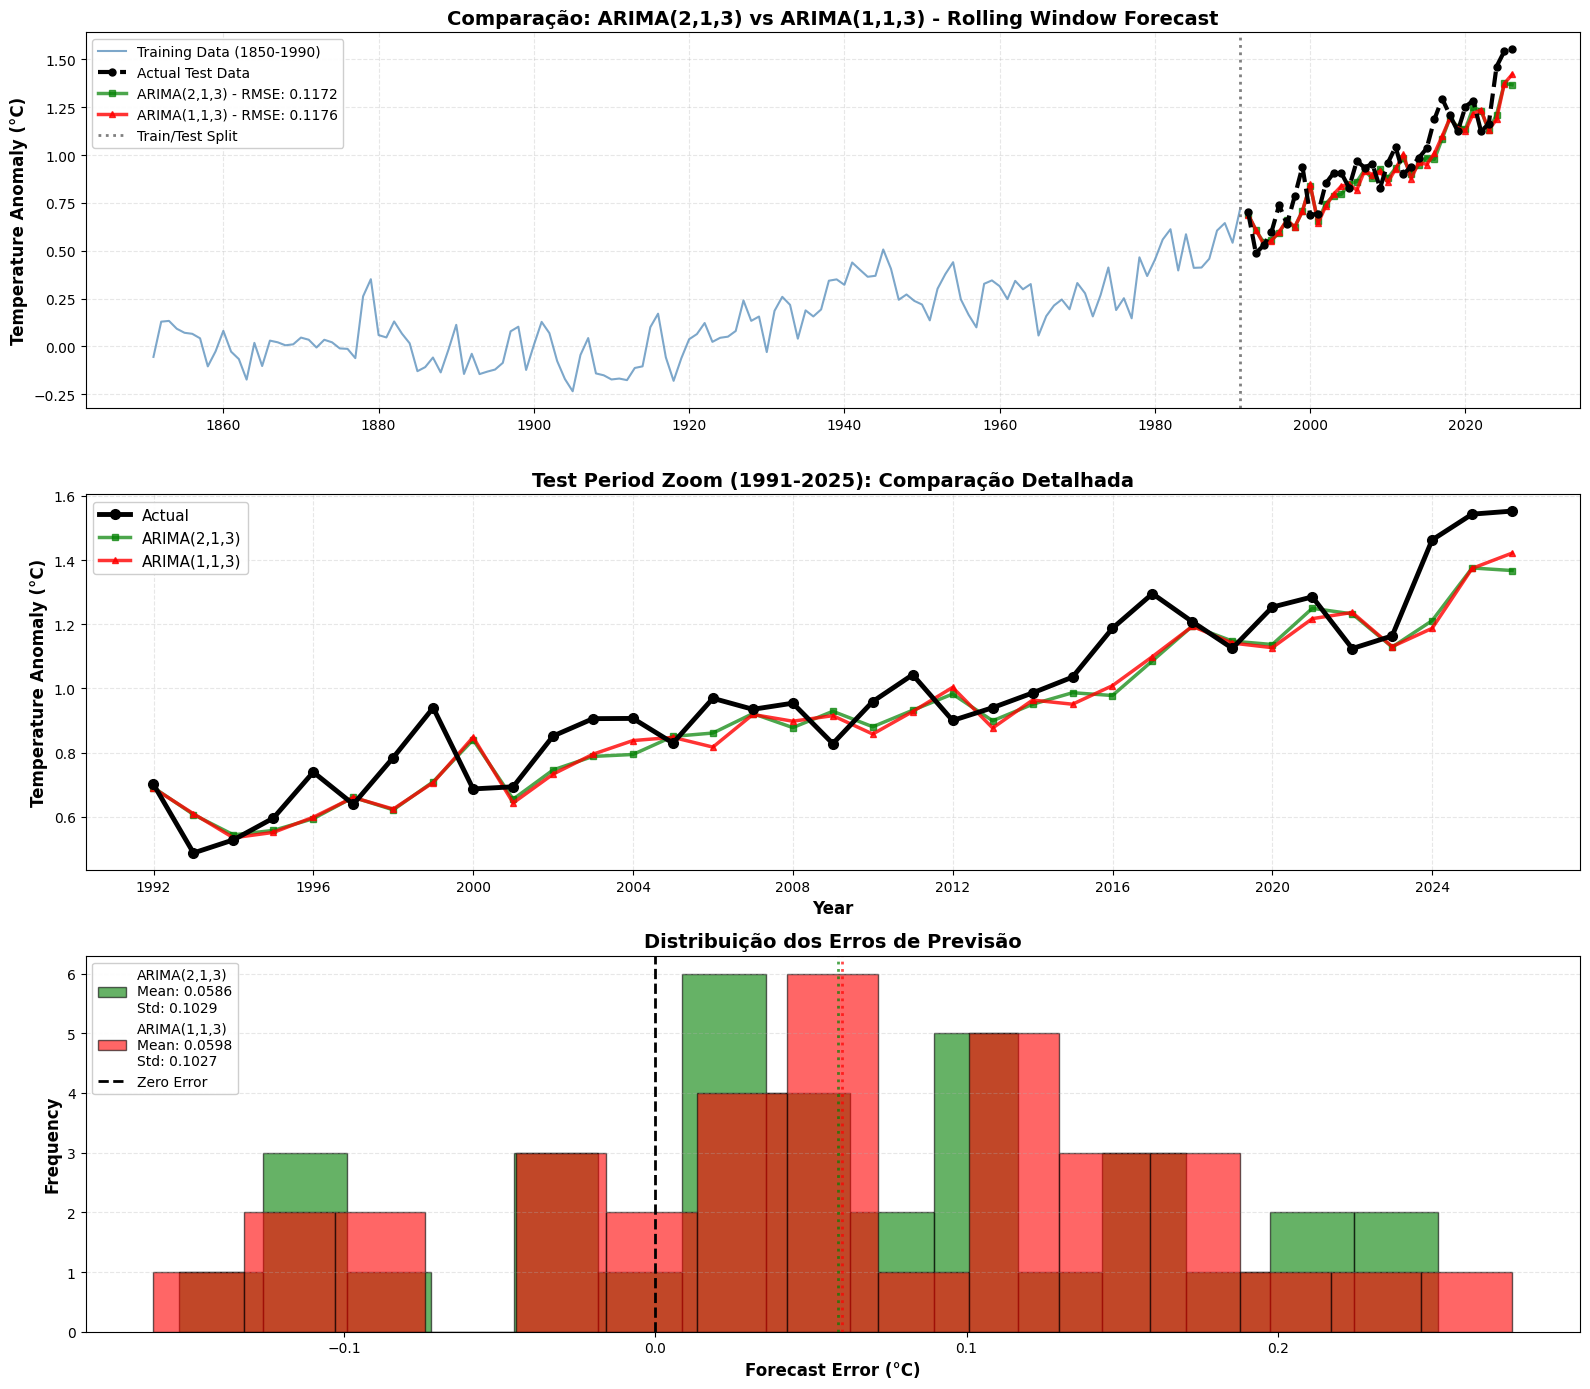

In [ ]:
# Série original
original_series = ts['Anomaly']
train_original = original_series[original_series.index.year <= 1990]
test_original = original_series[original_series.index.year > 1990]

print(f"\nDados: {len(original_series)} observações (1850-2025)")
print(f"Train: {len(train_original)} obs (1850-1990)")
print(f"Test:  {len(test_original)} obs (1991-2025)")

print("MODELO 1: ARIMA(2,1,3) - Modelo Original")

rolling_213 = []
rolling_dates = []

print("Progresso:", end=" ")
for i, date in enumerate(test_original.index):
    current_year = date.year
    train_rolling = original_series[original_series.index.year <= (1990 + i)]
    
    model = ARIMA(train_rolling, order=(2, 1, 3))
    fitted = model.fit()
    pred = fitted.get_forecast(steps=1).predicted_mean.iloc[0]
    
    rolling_213.append(pred)
    rolling_dates.append(date)
    
    if (i + 1) % 7 == 0:
        print(f"{i+1}", end=" ")

print()

rolling_213_series = pd.Series(rolling_213, index=rolling_dates)
rmse_213 = np.sqrt(mean_squared_error(test_original, rolling_213_series))
mae_213 = mean_absolute_error(test_original, rolling_213_series)

print(f"✓ ARIMA(2,1,3) completo")
print(f"  RMSE: {rmse_213:.6f}")
print(f"  MAE:  {mae_213:.6f}")

print("MODELO 2: ARIMA(1,1,3) - Modelo Otimizado (Grid Search)")
rolling_113 = []

print("Progresso:", end=" ")
for i, date in enumerate(test_original.index):
    current_year = date.year
    train_rolling = original_series[original_series.index.year <= (1990 + i)]
    
    model = ARIMA(train_rolling, order=(1, 1, 3))
    fitted = model.fit()
    pred = fitted.get_forecast(steps=1).predicted_mean.iloc[0]
    
    rolling_113.append(pred)
    
    if (i + 1) % 7 == 0:
        print(f"{i+1}", end=" ")

print()

rolling_113_series = pd.Series(rolling_113, index=rolling_dates)
rmse_113 = np.sqrt(mean_squared_error(test_original, rolling_113_series))
mae_113 = mean_absolute_error(test_original, rolling_113_series)

print(f"✓ ARIMA(1,1,3) completo")
print(f"  RMSE: {rmse_113:.6f}")
print(f"  MAE:  {mae_113:.6f}")

print("COMPARAÇÃO DE PERFORMANCE")
improvement_rmse = ((rmse_213 - rmse_113) / rmse_213) * 100
improvement_mae = ((mae_213 - mae_113) / mae_213) * 100

comparison_df = pd.DataFrame({
    'Modelo': ['ARIMA(2,1,3)', 'ARIMA(1,1,3)'],
    'RMSE': [rmse_213, rmse_113],
    'MAE': [mae_213, mae_113],
    'Δ RMSE (%)': [0, improvement_rmse],
    'Δ MAE (%)': [0, improvement_mae]
})

print(comparison_df.to_string(index=False))
print("="*70)

if rmse_113 < rmse_213:
    print(f"\n🎉 ARIMA(1,1,3) é MELHOR!")
    print(f"   Redução de {abs(improvement_rmse):.2f}% no RMSE")
    print(f"   Redução de {abs(improvement_mae):.2f}% no MAE")
else:
    print(f"\n⚠️  ARIMA(2,1,3) ainda é melhor")
    print(f"   Diferença: {abs(improvement_rmse):.2f}% no RMSE")

# Calcular erros de previsão
errors_213 = test_original - rolling_213_series
errors_113 = test_original - rolling_113_series

#Gráficos
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# --- GRÁFICO 1: SÉRIE TEMPORAL COMPLETA ---
ax1 = axes[0]

# Dados históricos
ax1.plot(train_original.index, train_original.values, 
         label='Training Data (1850-1990)', color='steelblue', linewidth=1.5, alpha=0.7)

# Dados reais de teste
ax1.plot(test_original.index, test_original.values, 
         label='Actual Test Data', color='black', linewidth=3, 
         linestyle='--', marker='o', markersize=5, zorder=10)

# Previsões ARIMA(2,1,3)
ax1.plot(rolling_213_series.index, rolling_213_series.values, 
         label=f'ARIMA(2,1,3) - RMSE: {rmse_213:.4f}', 
         color='green', linewidth=2.5, marker='s', markersize=4, alpha=0.7)

# Previsões ARIMA(1,1,3)
ax1.plot(rolling_113_series.index, rolling_113_series.values, 
         label=f'ARIMA(1,1,3) - RMSE: {rmse_113:.4f}', 
         color='red', linewidth=2.5, marker='^', markersize=4, alpha=0.8)

ax1.axvline(x=train_original.index[-1], color='gray', linestyle=':', linewidth=2, 
            label='Train/Test Split')

ax1.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax1.set_title('Comparação: ARIMA(2,1,3) vs ARIMA(1,1,3) - Rolling Window Forecast', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax1.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 2: ZOOM NO PERÍODO DE TESTE ---
ax2 = axes[1]

# Dados reais
ax2.plot(test_original.index, test_original.values, 
         label='Actual', color='black', linewidth=3.5, 
         marker='o', markersize=7, zorder=10, linestyle='-')

# Previsões
ax2.plot(rolling_213_series.index, rolling_213_series.values, 
         label='ARIMA(2,1,3)', color='green', linewidth=2.5, 
         marker='s', markersize=5, alpha=0.7, linestyle='-')

ax2.plot(rolling_113_series.index, rolling_113_series.values, 
         label='ARIMA(1,1,3)', color='red', linewidth=2.5, 
         marker='^', markersize=5, alpha=0.8, linestyle='-')

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax2.set_title('Test Period Zoom (1991-2025): Comparação Detalhada', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax2.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 3: DISTRIBUIÇÃO DOS ERROS ---
ax3 = axes[2]

# Histogramas
ax3.hist(errors_213, bins=15, alpha=0.6, color='green', 
         edgecolor='black', label=f'ARIMA(2,1,3)\nMean: {errors_213.mean():.4f}\nStd: {errors_213.std():.4f}')
ax3.hist(errors_113, bins=15, alpha=0.6, color='red', 
         edgecolor='black', label=f'ARIMA(1,1,3)\nMean: {errors_113.mean():.4f}\nStd: {errors_113.std():.4f}')

ax3.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=errors_213.mean(), color='green', linestyle=':', linewidth=2, alpha=0.7)
ax3.axvline(x=errors_113.mean(), color='red', linestyle=':', linewidth=2, alpha=0.7)

ax3.set_xlabel('Forecast Error (°C)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Distribuição dos Erros de Previsão', fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('arima_comparison_113_vs_213.png', dpi=300, bbox_inches='tight')
plt.show()

With this we can see that the model MA(2) converges to the mean after 2 steps. In order to try to overpass the MA(2) limitation, one possibilty is to apply the forecast 1-step ahead at each time

In [ ]:
# Rolling 1-step ahead forecasts
predictions = []
for i in range(len(test_data)):
    train_temp = ts[:train_size + i]
    model_temp = ARIMA(train_temp['Anomaly'], order=(0, 0, 2))
    fitted_temp = model_temp.fit()
    pred = fitted_temp.forecast(steps=1)
    predictions.append(pred.values[0])

NameError: name 'test_data' is not defined

In [ ]:
# Step 1: Split your data
train_size = len(ts) - 20  # Reserve last 20 observations for testing
train_data = ts[:train_size]
test_data = ts[train_size:]

# Step 2: Rolling 1-step ahead forecasts
predictions_1step = []
actual_values = []

for i in range(len(test_data)):
    # Expand training set by one observation each iteration
    train_temp = ts[:train_size + i]
    
    # Fit MA(2) model
    model_temp = ARIMA(train_temp['Anomaly'], order=(0, 0, 2))
    fitted_temp = model_temp.fit()
    
    # Forecast 1 step ahead
    pred = fitted_temp.forecast(steps=1)
    predictions_1step.append(pred.values[0])
    actual_values.append(test_data['Anomaly'].iloc[i])
    
    print(f"Step {i+1}: Actual = {test_data['Anomaly'].iloc[i]:.4f}, Predicted = {pred.values[0]:.4f}")

# Step 3: Calculate performance metrics
predictions_1step = np.array(predictions_1step)
actual_values = np.array(actual_values)

mae_1step = mean_absolute_error(actual_values, predictions_1step)
rmse_1step = np.sqrt(mean_squared_error(actual_values, predictions_1step))
mape_1step = np.mean(np.abs((actual_values - predictions_1step) / actual_values)) * 100

print(f"\n=== Rolling 1-Step Ahead Forecast Performance ===")
print(f"MAE: {mae_1step:.4f}")
print(f"RMSE: {rmse_1step:.4f}")
print(f"MAPE: {mape_1step:.2f}%")

# Step 4: Visualize rolling forecasts
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, actual_values, label='Actual', color='blue', marker='o', linewidth=2)
plt.plot(test_data.index, predictions_1step, label='Rolling 1-Step Forecast', color='red', marker='x', linestyle='--', linewidth=2)
plt.title('MA(2) Rolling 1-Step Ahead Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 5: Plot forecast errors
errors = actual_values - predictions_1step

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(test_data.index, errors, color='purple', marker='o')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Forecast Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)


The rolling forecast evaluation demonstrates that MA(2) provides reliable short-term predictions (1-step ahead), with accuracy degrading for longer horizons. Thus, since we need longer-term forecasts, we will apply the ARMA model since it combines both behaviours.

In [ ]:
# Fit ARMA(3,2) on full data
model_arma = ARIMA(ts['Anomaly'], order=(3, 0, 2))
fitted_arma = model_arma.fit()
print(fitted_arma.summary())

# Generate long-term forecast (12 steps ahead)
h = 12
forecast_arma = fitted_arma.forecast(steps=h)
forecast_arma_ci = fitted_arma.get_forecast(steps=h).conf_int()

print("\n=== ARMA(3,2) Forecast ===")
print(forecast_arma)

In [ ]:
# Also get MA(2) forecast for comparison
model_ma = ARIMA(ts['Anomaly'], order=(0, 0, 2))
fitted_ma = model_ma.fit()
forecast_ma = fitted_ma.forecast(steps=h)

# Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts['Anomaly'], label='Historical Data', color='blue', linewidth=1.5)
plt.plot(forecast_ma.index, forecast_ma, label='MA(2) Forecast', color='red', linestyle='--', marker='o', linewidth=2)
plt.plot(forecast_arma.index, forecast_arma, label='ARMA(3,2) Forecast', color='green', linestyle='--', marker='s', linewidth=2)
plt.fill_between(forecast_arma.index, 
                 forecast_arma_ci.iloc[:, 0], 
                 forecast_arma_ci.iloc[:, 1], 
                 color='lightgreen', alpha=0.3, label='ARMA 95% CI')
plt.title('MA(2) vs ARMA(3,2) Forecasts Comparison')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=ts.index[-1], color='black', linestyle=':', linewidth=1)
plt.tight_layout()
plt.show()

In [ ]:
# Split data
train_size = len(ts) - 20
train_data = ts[:train_size]
test_data = ts[train_size:]

# Rolling forecasts for MA(2)
predictions_ma = []
for i in range(len(test_data)):
    train_temp = ts[:train_size + i]
    model_temp = ARIMA(train_temp['Anomaly'], order=(0, 0, 2))
    fitted_temp = model_temp.fit()
    pred = fitted_temp.forecast(steps=1)
    predictions_ma.append(pred.values[0])

# Rolling forecasts for ARMA(3,2)
predictions_arma = []
for i in range(len(test_data)):
    train_temp = ts[:train_size + i]
    model_temp = ARIMA(train_temp['Anomaly'], order=(3, 0, 2))
    fitted_temp = model_temp.fit()
    pred = fitted_temp.forecast(steps=1)
    predictions_arma.append(pred.values[0])

predictions_ma = np.array(predictions_ma)
predictions_arma = np.array(predictions_arma)
actual_values = test_data['Anomaly'].values

# Calculate metrics for both models
mae_ma = mean_absolute_error(actual_values, predictions_ma)
rmse_ma = np.sqrt(mean_squared_error(actual_values, predictions_ma))
mape_ma = np.mean(np.abs((actual_values - predictions_ma) / actual_values)) * 100

mae_arma = mean_absolute_error(actual_values, predictions_arma)
rmse_arma = np.sqrt(mean_squared_error(actual_values, predictions_arma))
mape_arma = np.mean(np.abs((actual_values - predictions_arma) / actual_values)) * 100

print("\n=== Rolling 1-Step Ahead Forecast Comparison ===")
print(f"\nMA(2) Performance:")
print(f"  MAE:  {mae_ma:.4f}")
print(f"  RMSE: {rmse_ma:.4f}")
print(f"  MAPE: {mape_ma:.2f}%")

print(f"\nARMA(3,2) Performance:")
print(f"  MAE:  {mae_arma:.4f}")
print(f"  RMSE: {rmse_arma:.4f}")
print(f"  MAPE: {mape_arma:.2f}%")

print(f"\nImprovement:")
print(f"  MAE:  {((mae_ma - mae_arma) / mae_ma * 100):.2f}%")
print(f"  RMSE: {((rmse_ma - rmse_arma) / rmse_ma * 100):.2f}%")

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, actual_values, label='Actual', color='blue', marker='o', linewidth=2, markersize=6)
plt.plot(test_data.index, predictions_ma, label='MA(2) Forecast', color='red', marker='x', linestyle='--', linewidth=2, markersize=8)
plt.plot(test_data.index, predictions_arma, label='ARMA(3,2) Forecast', color='green', marker='s', linestyle='--', linewidth=2, markersize=6)
plt.title('Rolling 1-Step Ahead Forecasts: MA(2) vs ARMA(3,2)')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Error distribution ARMA(3,2)
errors_arma = actual_values - predictions_arma
axes[1, 0].hist(errors_arma, bins=10, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_title('ARMA(3,2) Error Distribution')
axes[1, 0].set_xlabel('Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

While MA(2) demonstrated the best in-sample fit based on AIC/BIC criteria, its forecasting capability is limited due to the finite memory property of moving average models. To address this limitation, we also evaluated the ARMA(3,2) model for forecasting purposes. The ARMA model combines autoregressive components that provide longer memory, potentially improving forecast accuracy beyond 2-step horizons.